In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "ehsanap"
os.environ['KAGGLE_KEY'] = ""
!kaggle competitions download -c home-credit-default-risk

 99% 684M/688M [00:03<00:00, 251MB/s]
100% 688M/688M [00:03<00:00, 216MB/s]


In [5]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/home-credit-default-risk.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [6]:
print(os.listdir('/content'))

['.config', 'application_test.csv', 'previous_application.csv', 'bureau.csv', 'application_train.csv', 'sample_submission.csv', 'credit_card_balance.csv', 'POS_CASH_balance.csv', 'installments_payments.csv', 'HomeCredit_columns_description.csv', 'bureau_balance.csv', 'home-credit-default-risk.zip', 'sample_data']


In [11]:
import os

dir_ad = '/content'
# dir_ad = os.getcwd()

train = 'application_train.csv'
test = 'application_test.csv'

tag = 's_result'

model_dir = os.path.join(dir_ad, tag + '_v')

target = 'TARGET'

index_col = 'SK_ID_CURR'

choice = "roc_auc"

In [9]:
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

In [12]:
df_train = pd.read_csv(os.path.join(dir_ad, train))
df_test = pd.read_csv(os.path.join(dir_ad, test))

In [13]:
num_cols = [col for col in df_test.columns if df_test[col].dtype in ["float16","float32","float64", "int64", "int32"]]
cat_cols = [col for col in df_test.columns if df_test[col].dtype not in ["float16","float32","float64", "int64", "int32"]]

In [14]:
def detect_outliers(data, col_name):
    outlier_indices = []
    for col in col_name:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [15]:
def outlier_replace(data, col_name, q1=0.25, q3=0.75):
    quartile1 = data[col_name].quantile(q1)
    quartile3 = data[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    data.loc[(data[col_name] < low_limit), col_name] = low_limit
    data.loc[(data[col_name] > up_limit), col_name] = up_limit

In [16]:
for i in num_cols:
    outlier_replace(df_train,i)
    outlier_replace(df_test, i)

In [17]:
df_train = df_train.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df_test = df_test.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

In [18]:
def count_plot(d, y, x):
    plt.figure(figsize=(12,6))
    sns.countplot(x = d[y], hue = x, data=d)
    plt.ylabel('Number of people')
    plt.title('Survival count by '+ x)

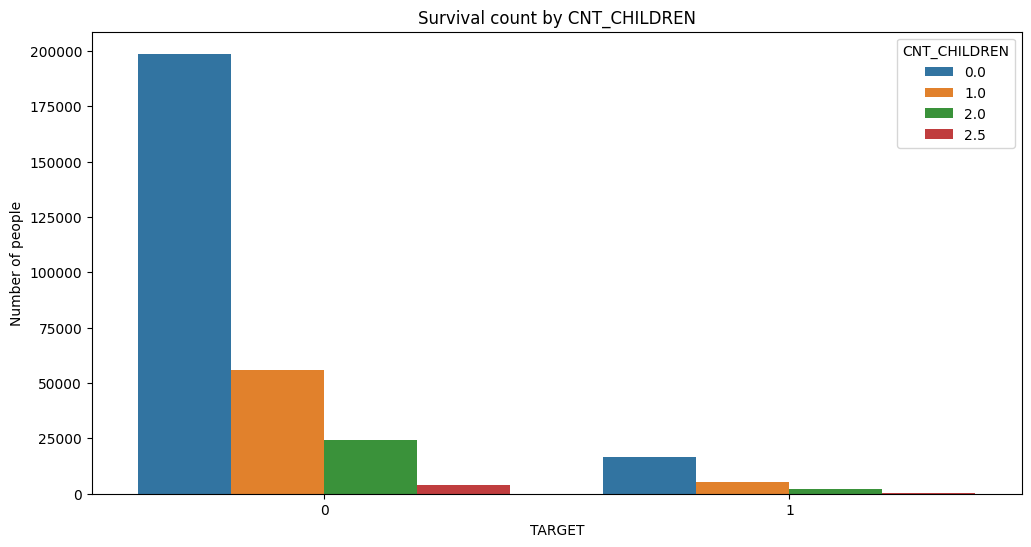

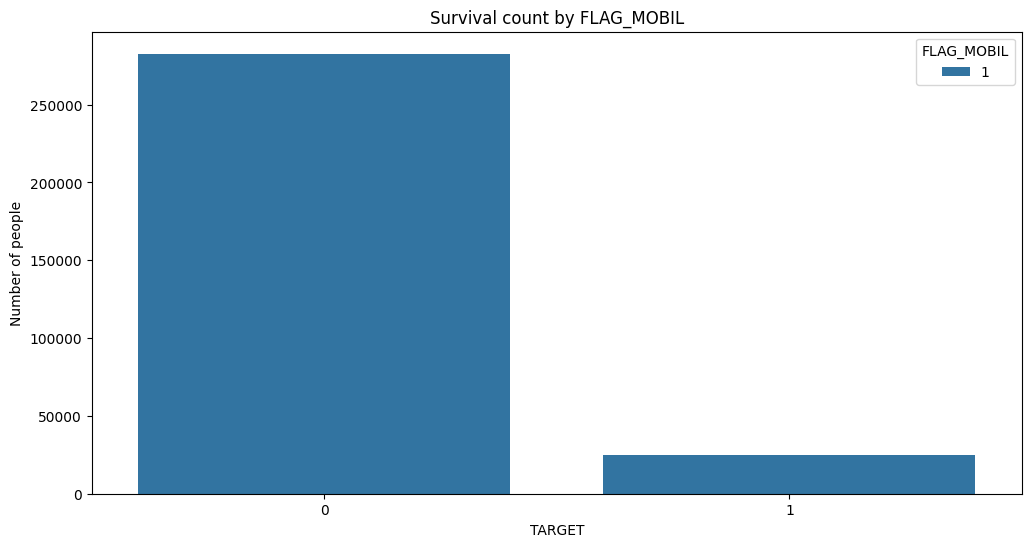

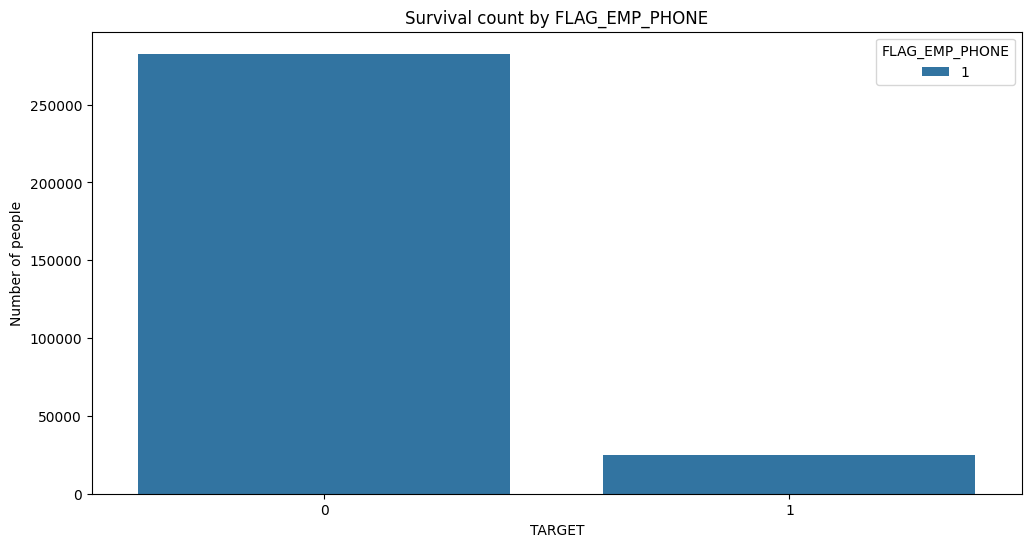

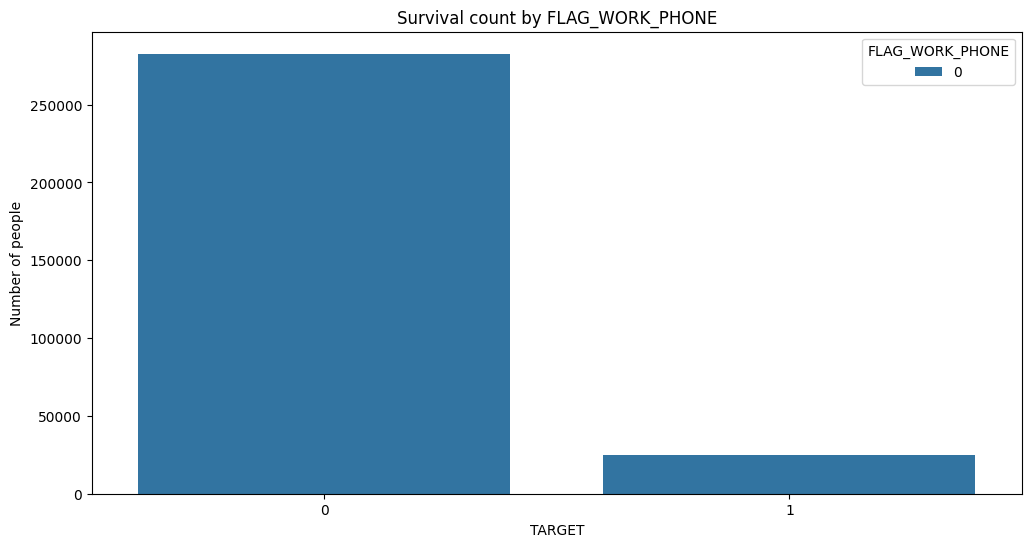

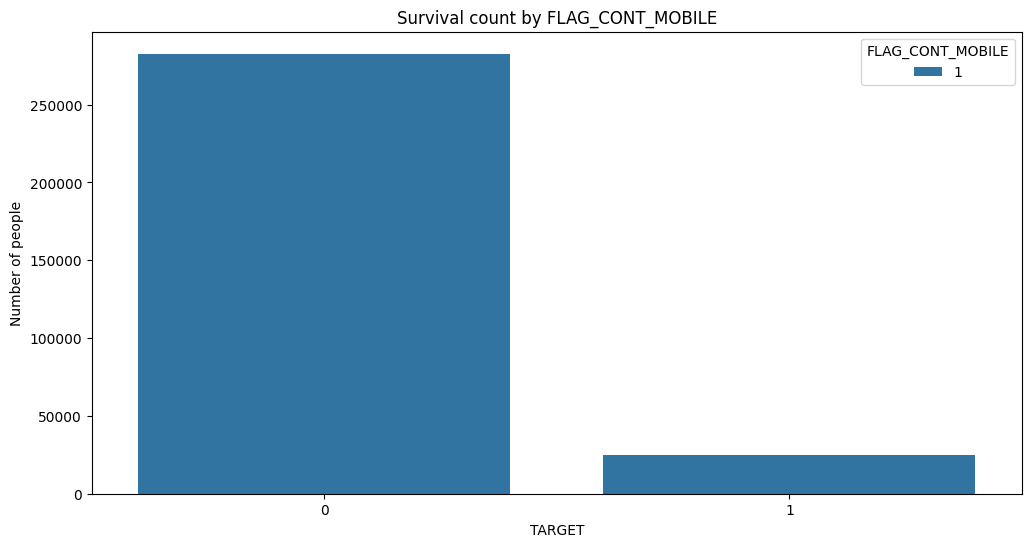

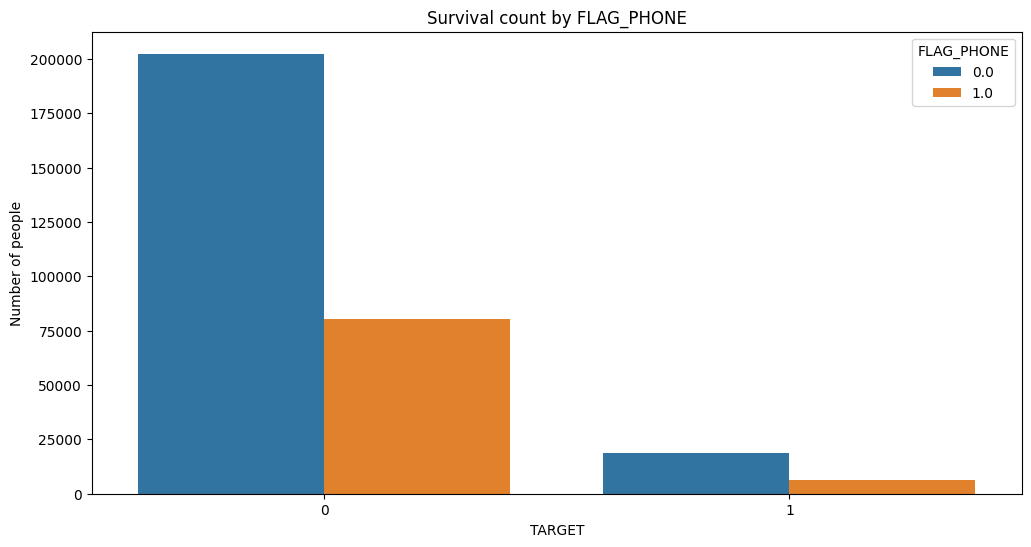

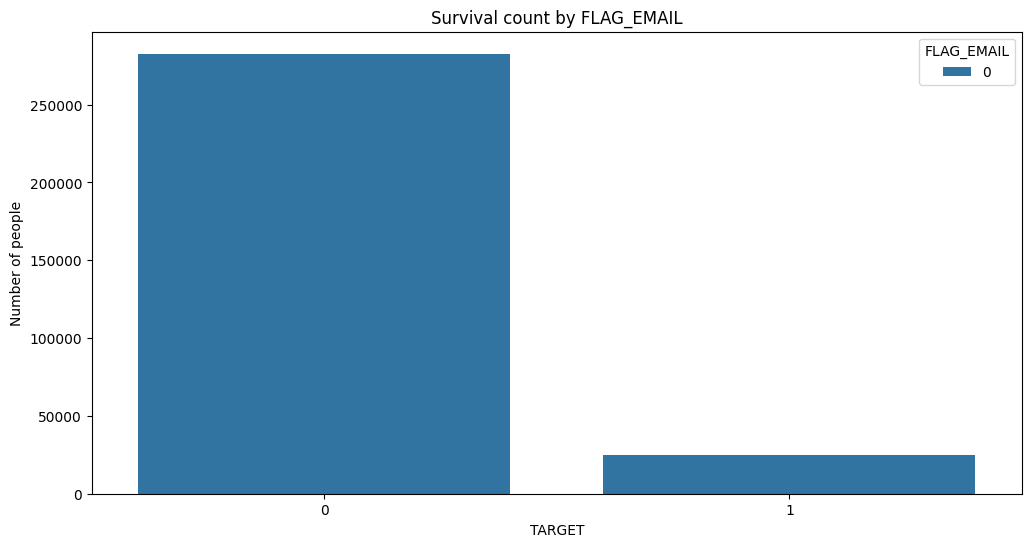

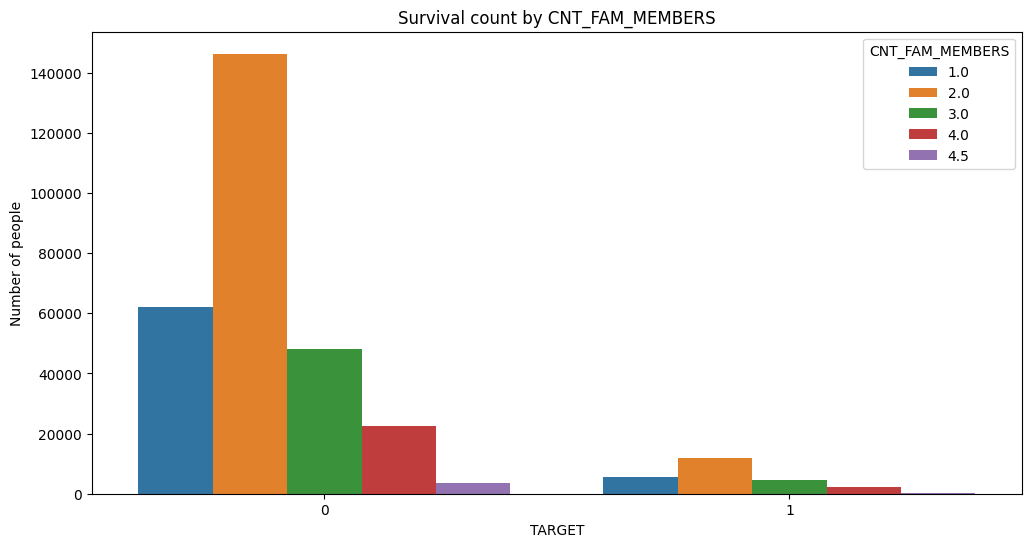

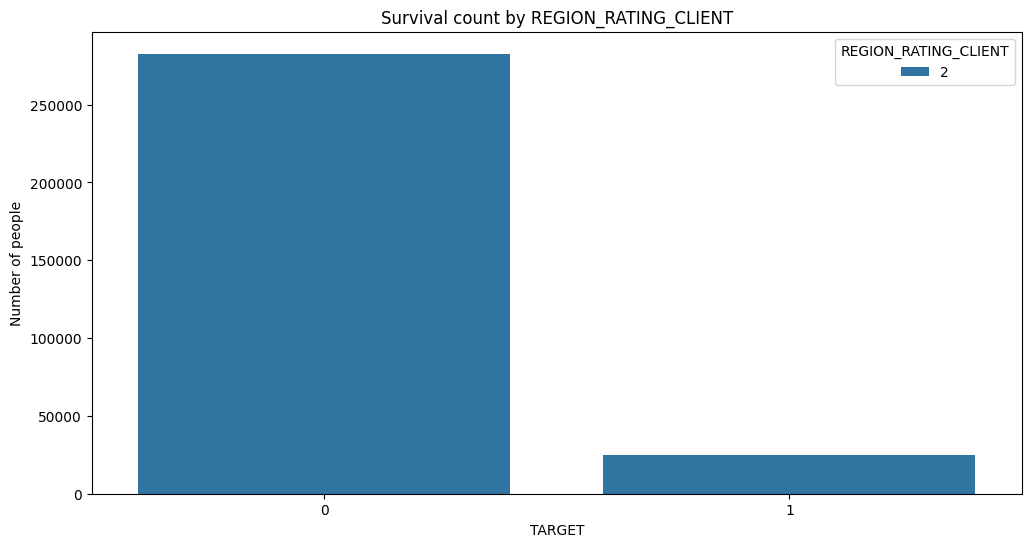

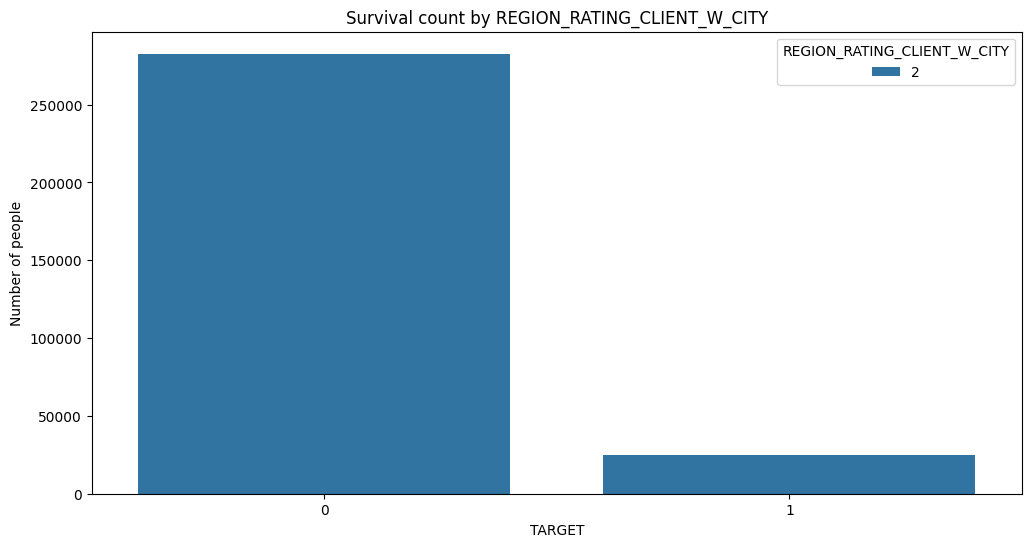

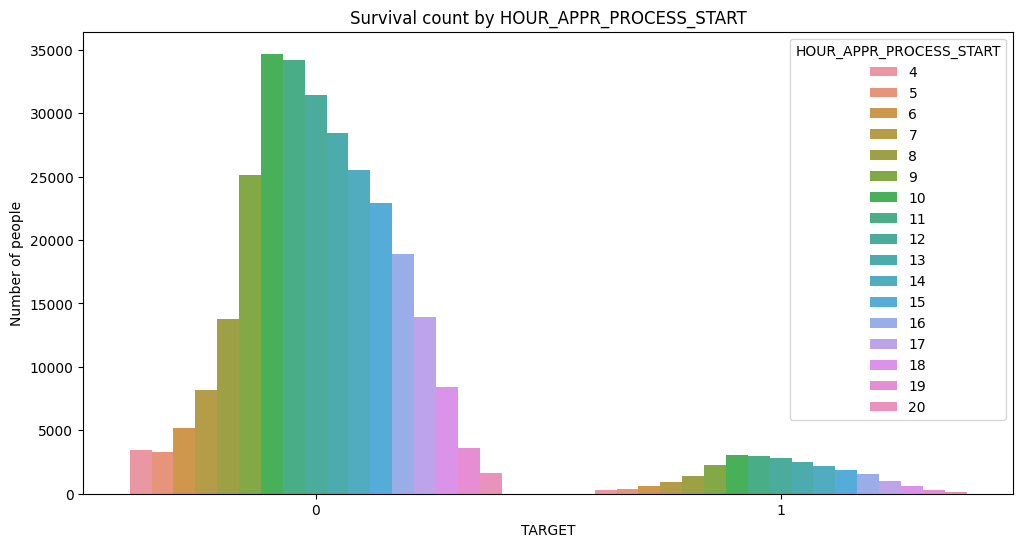

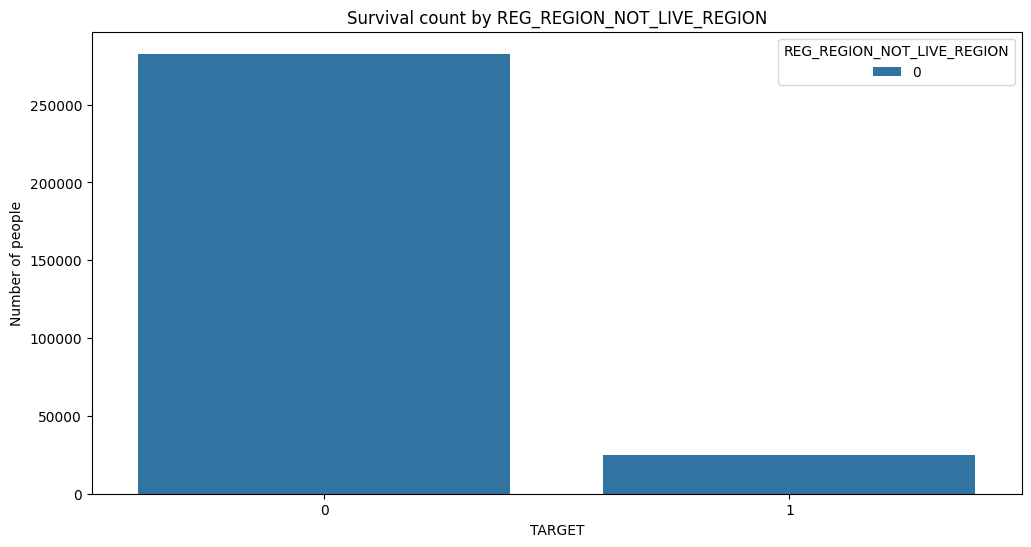

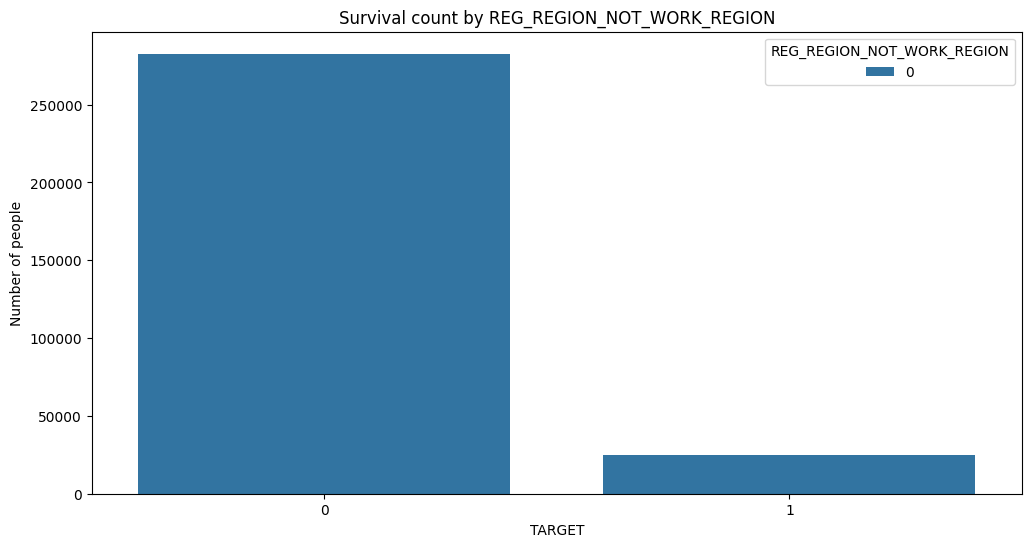

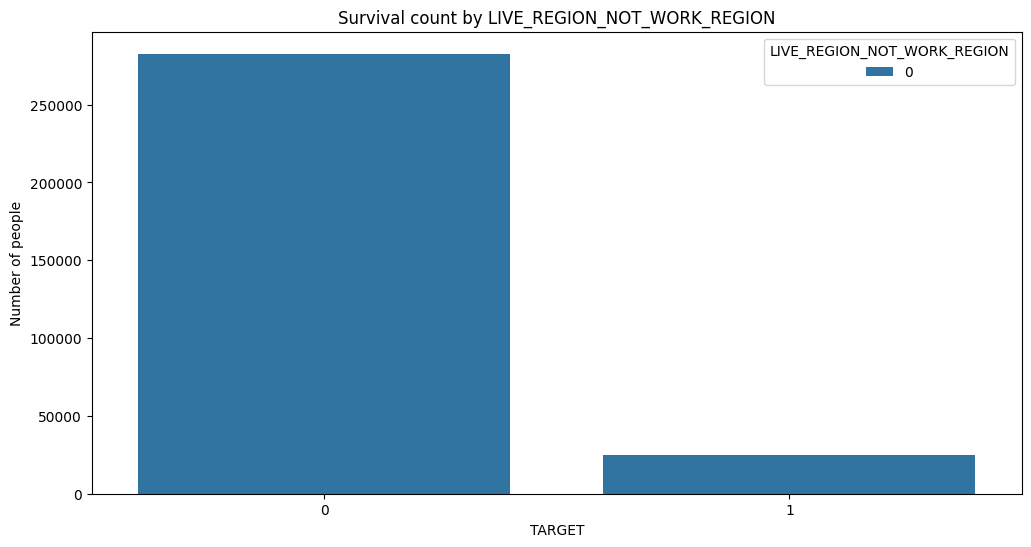

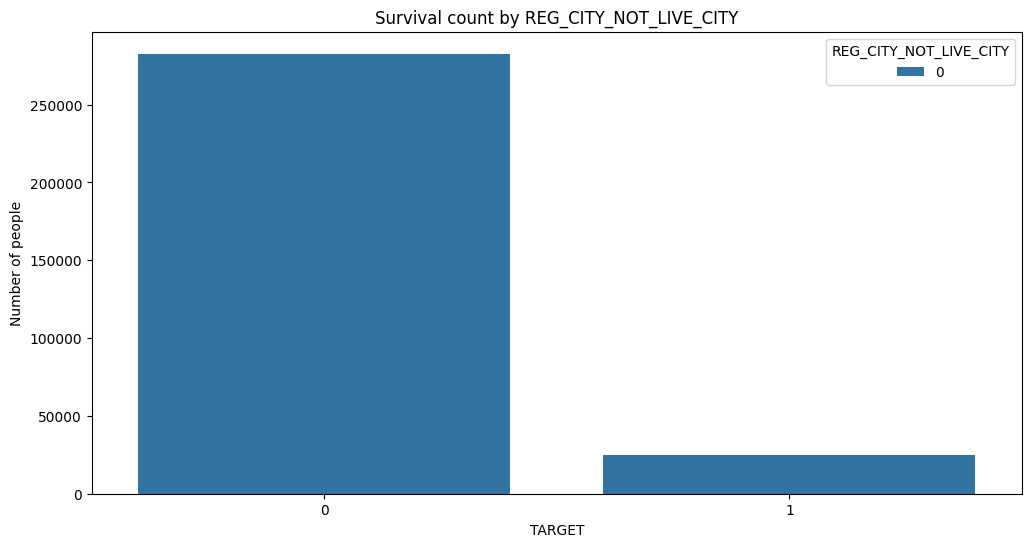

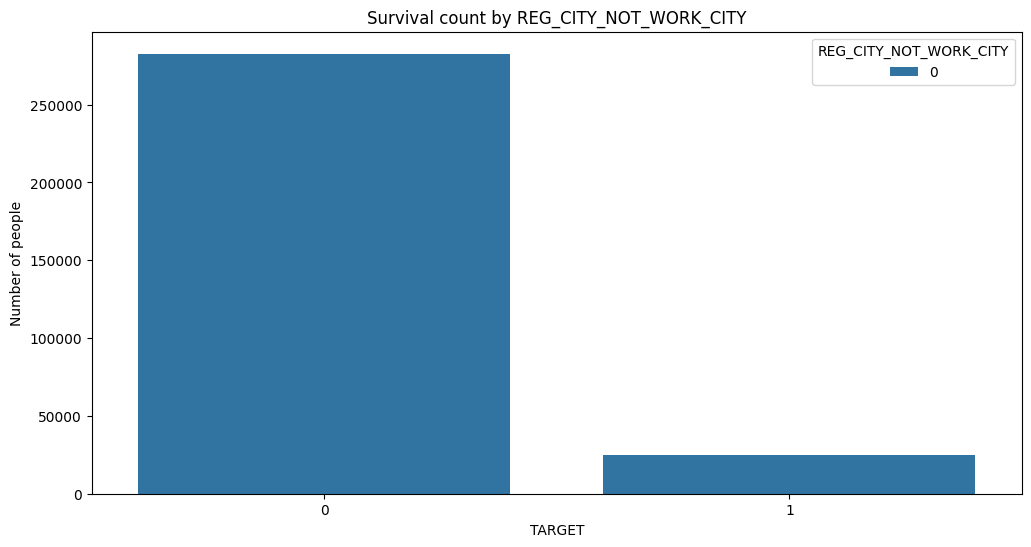

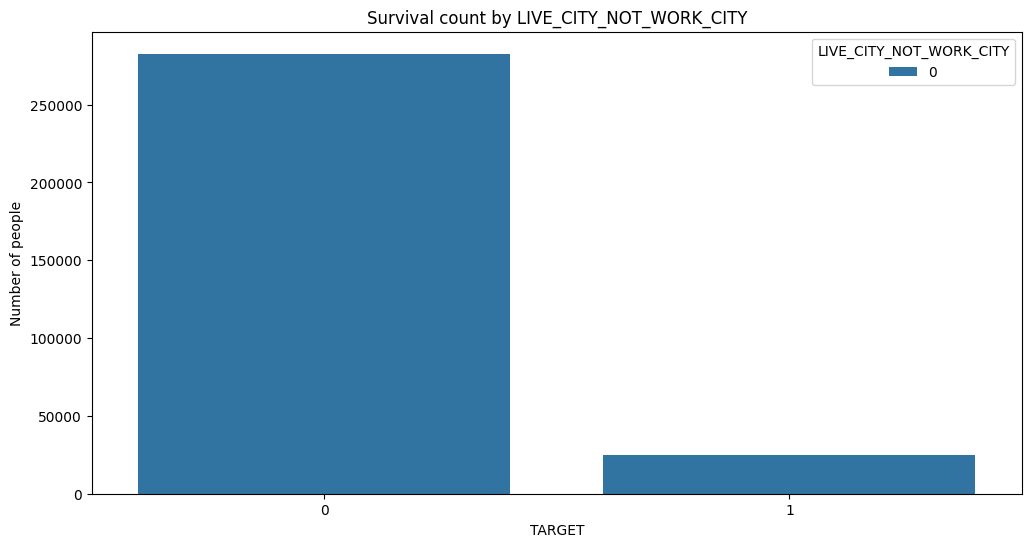

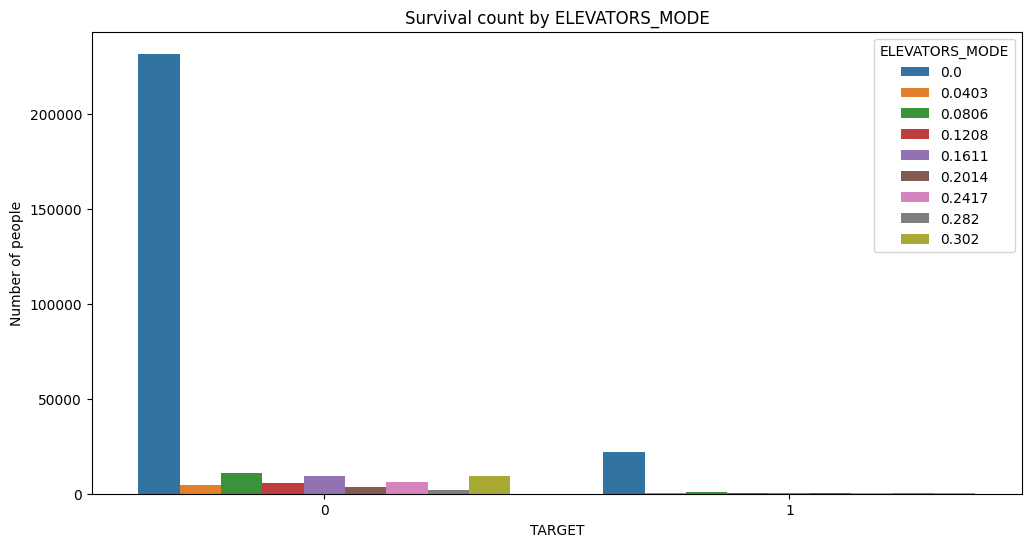

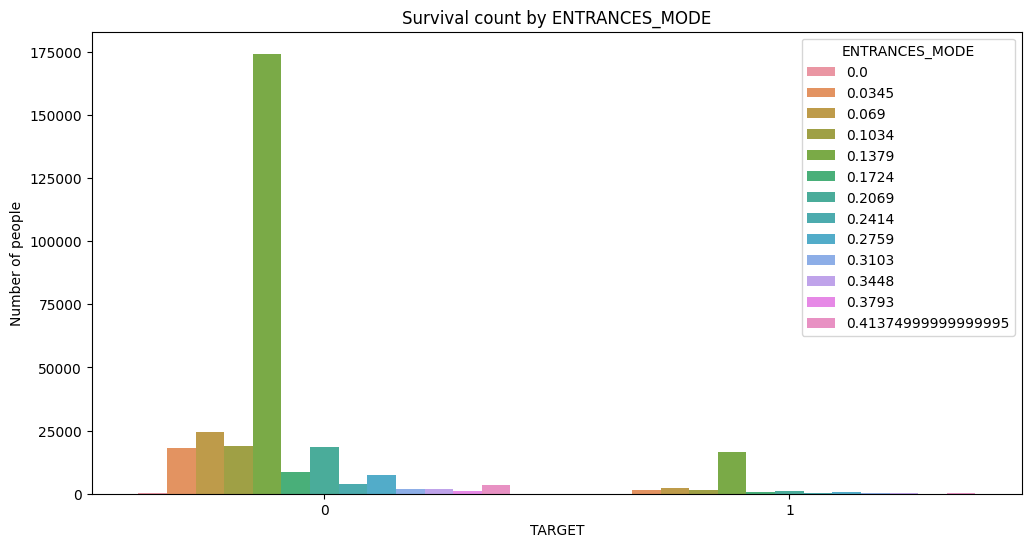

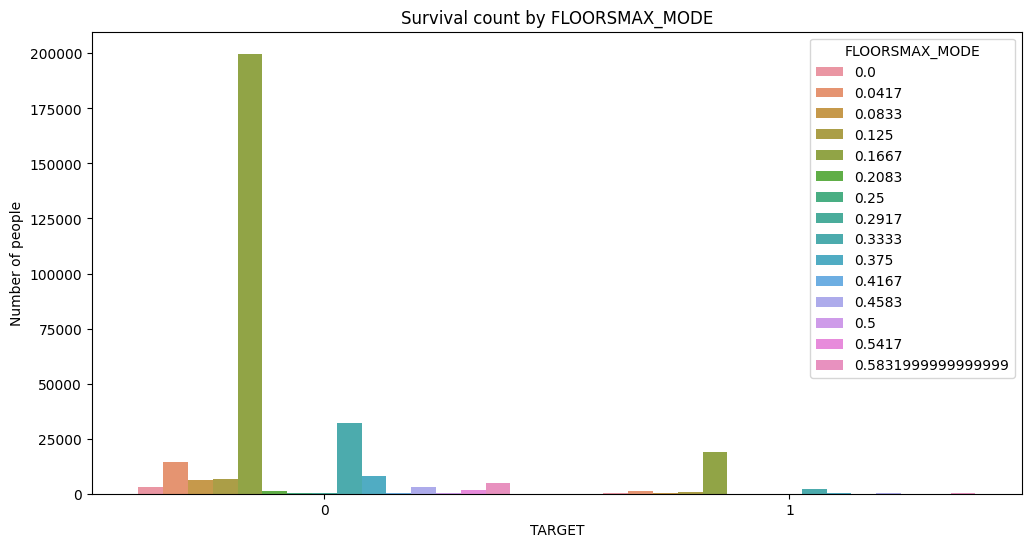

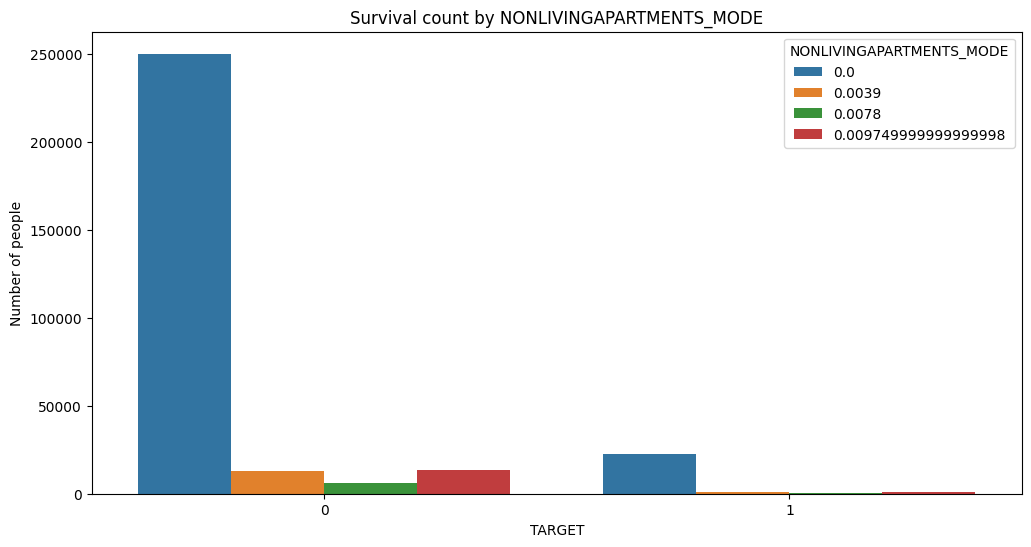

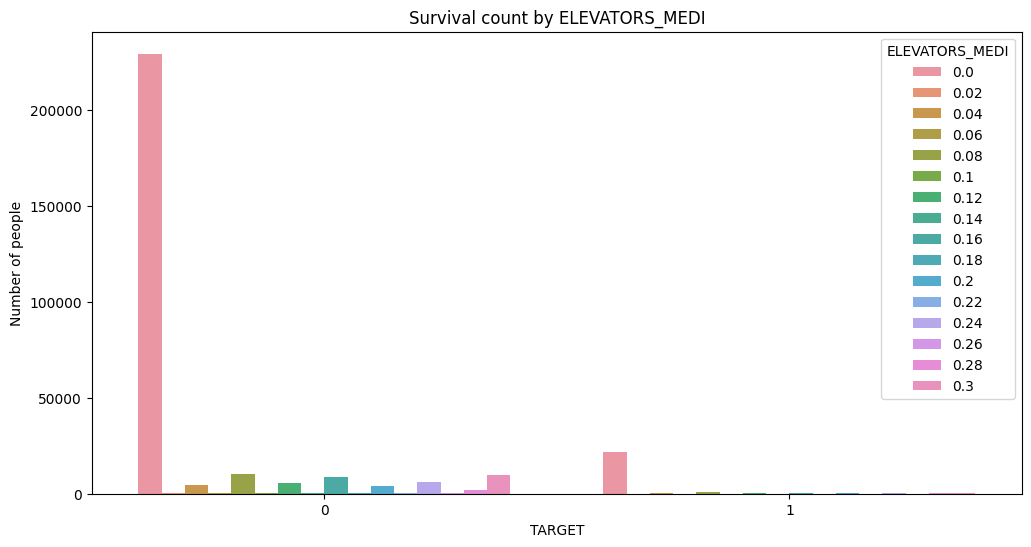

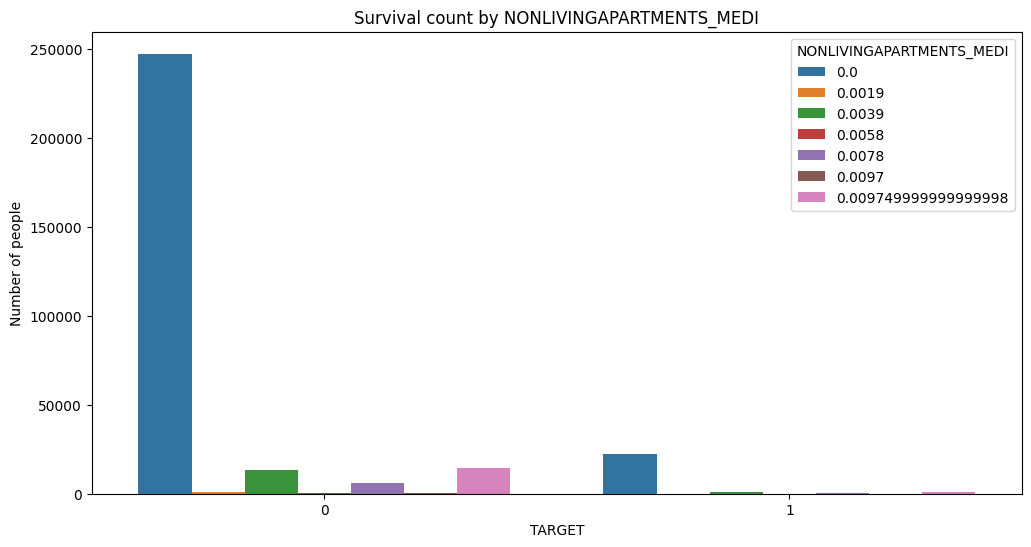

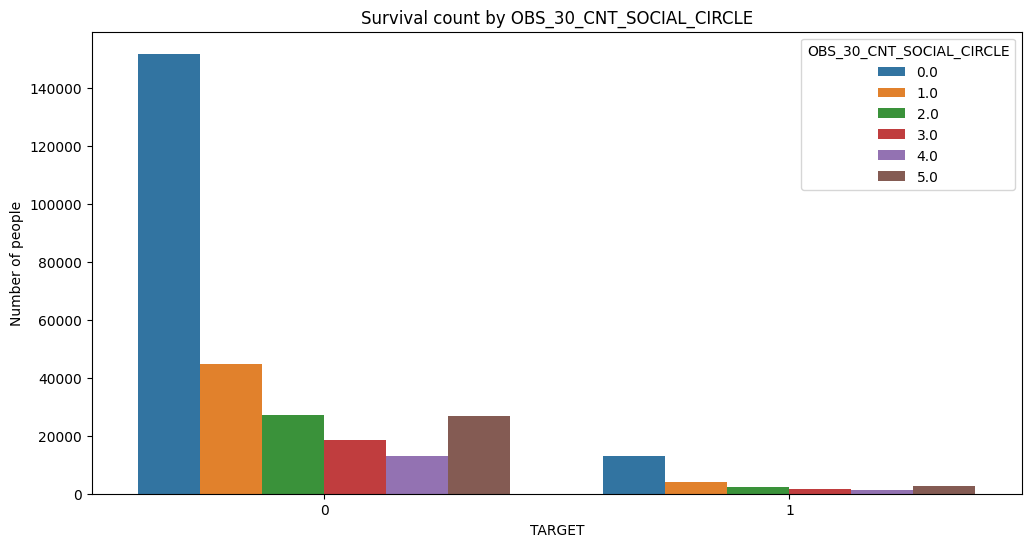

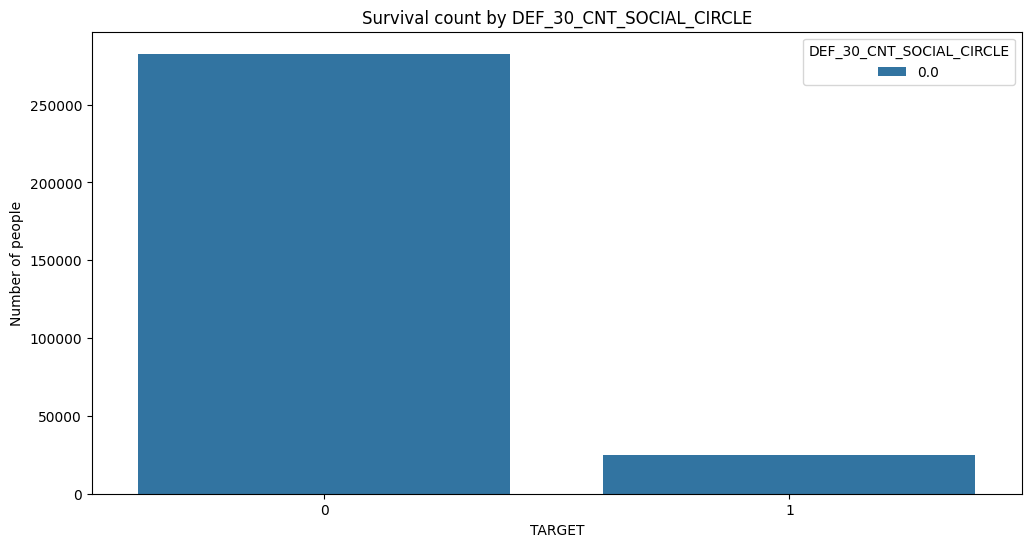

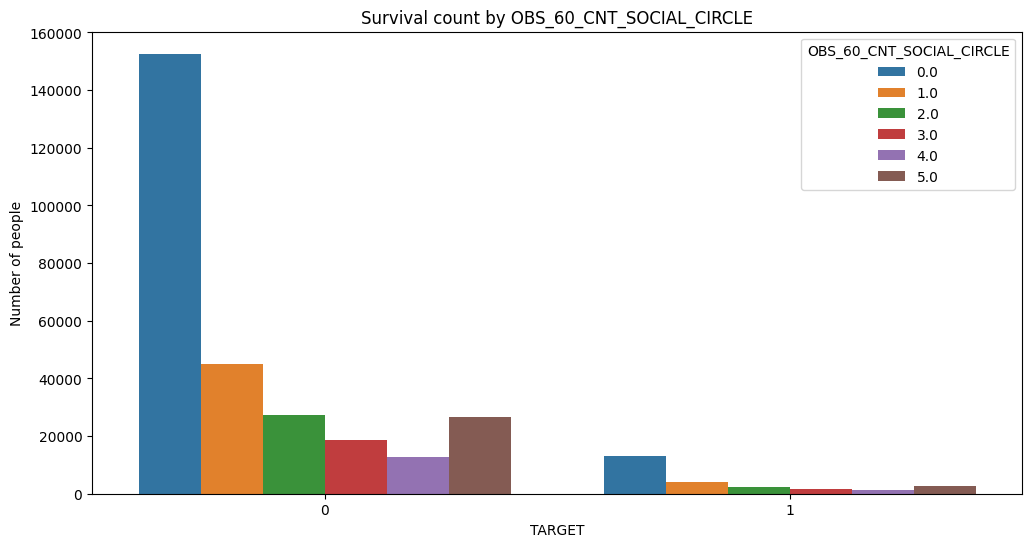

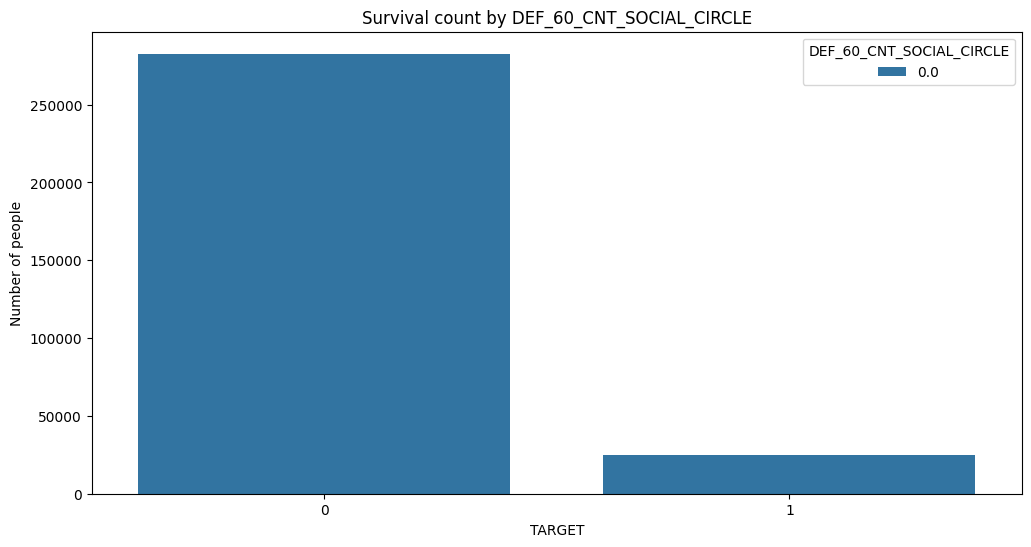

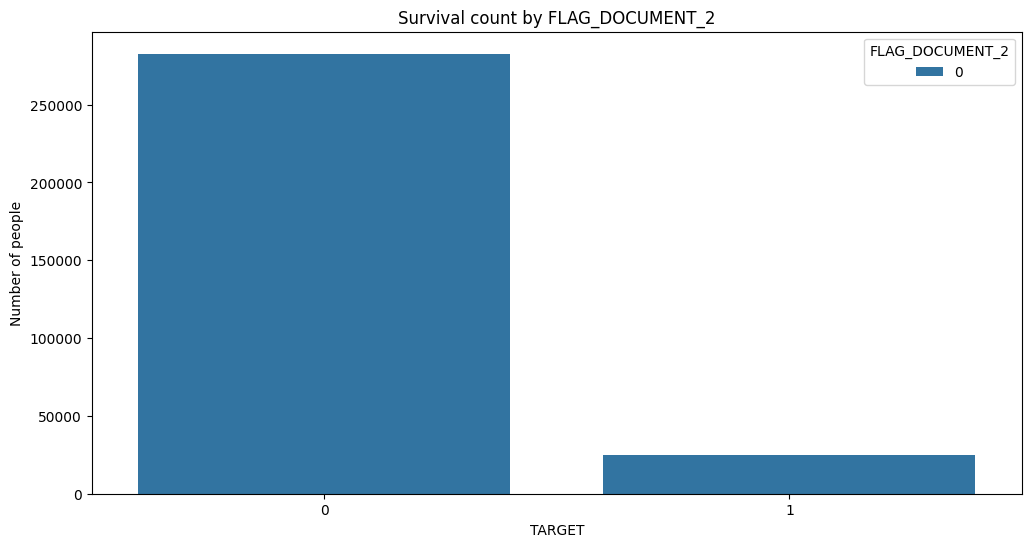

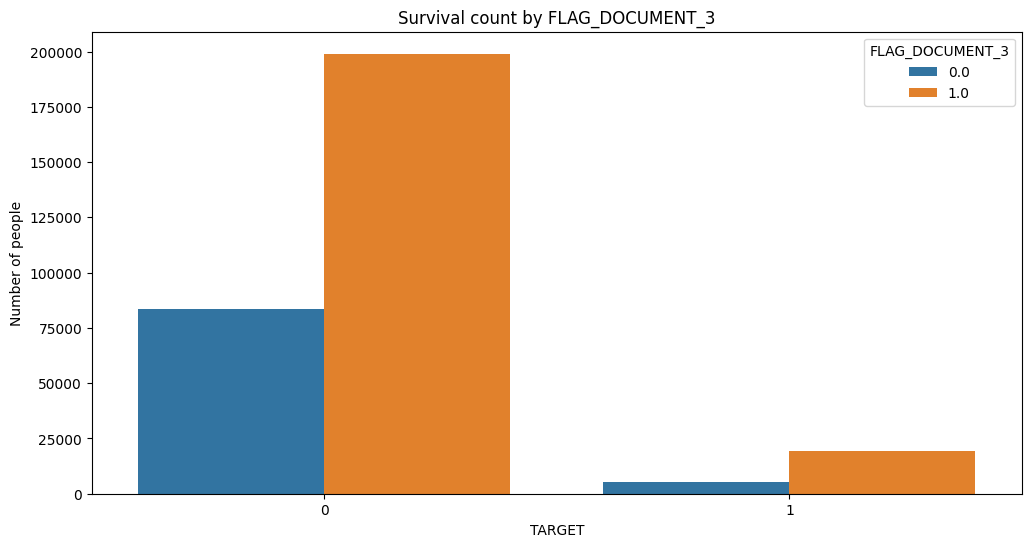

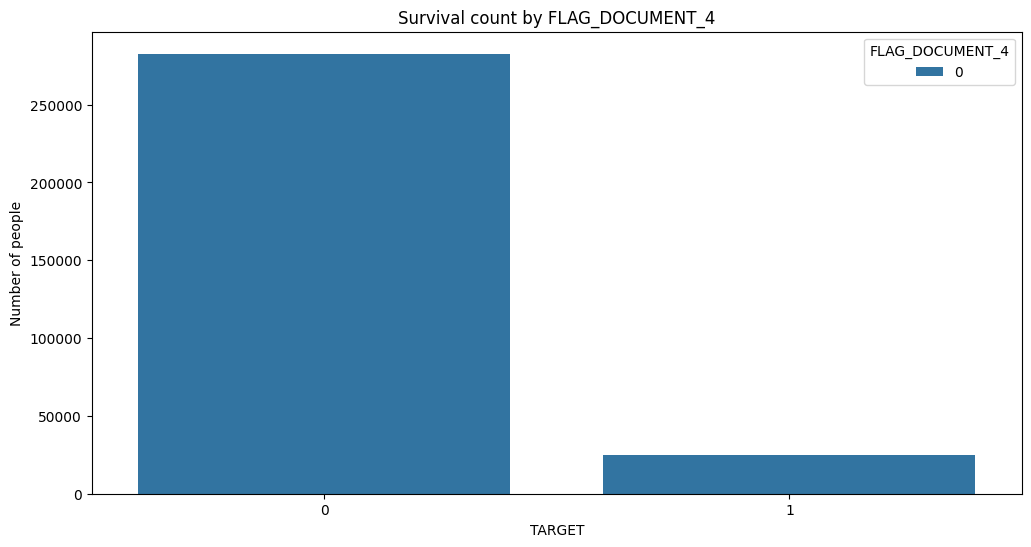

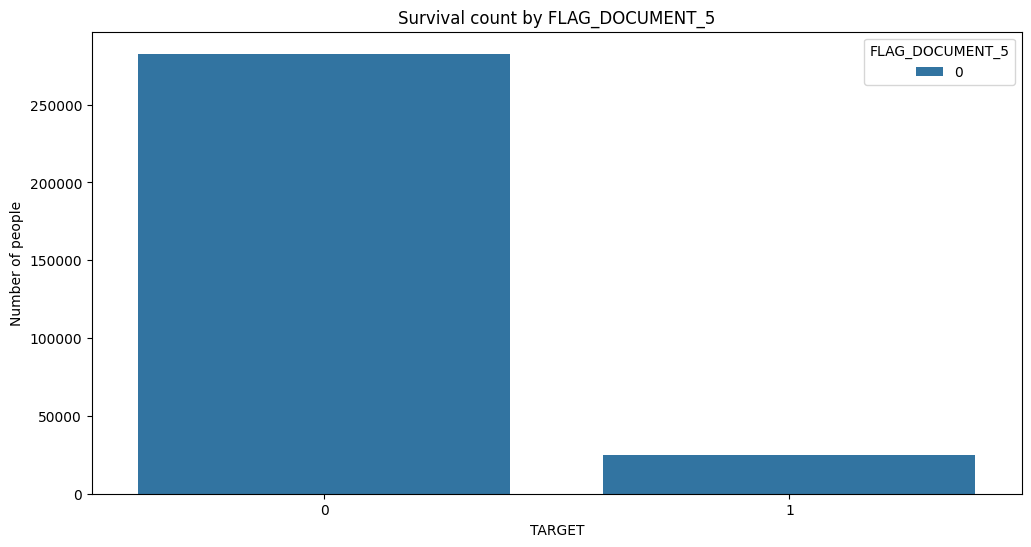

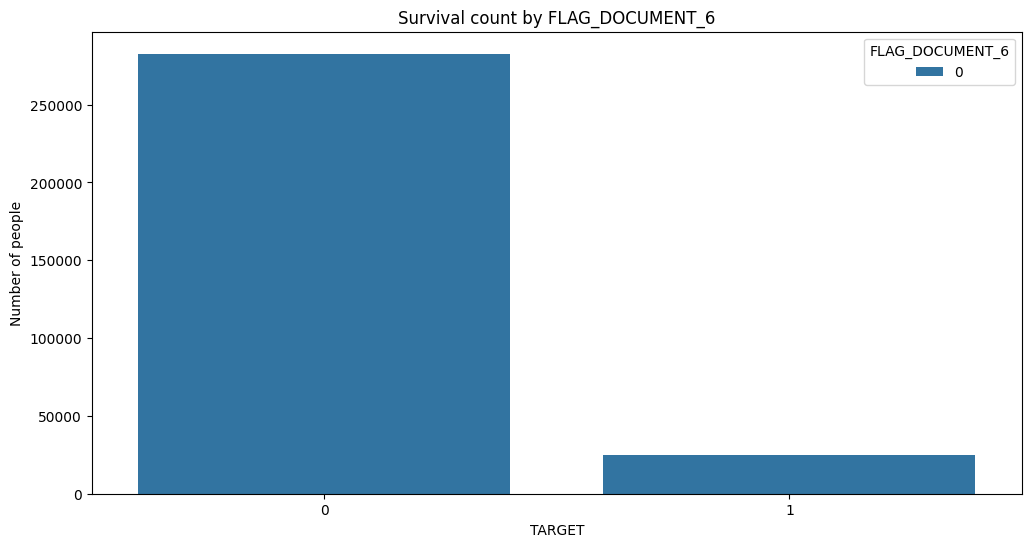

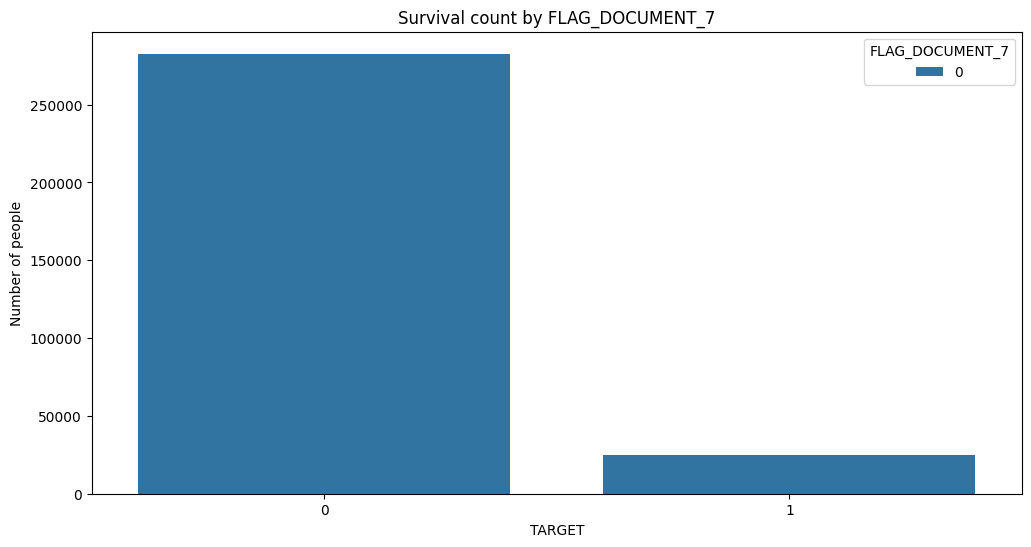

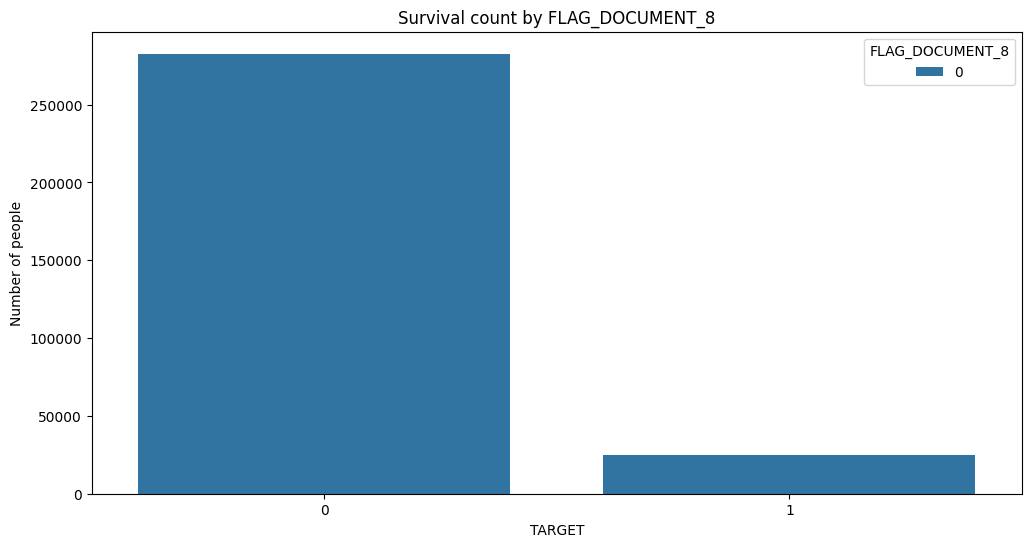

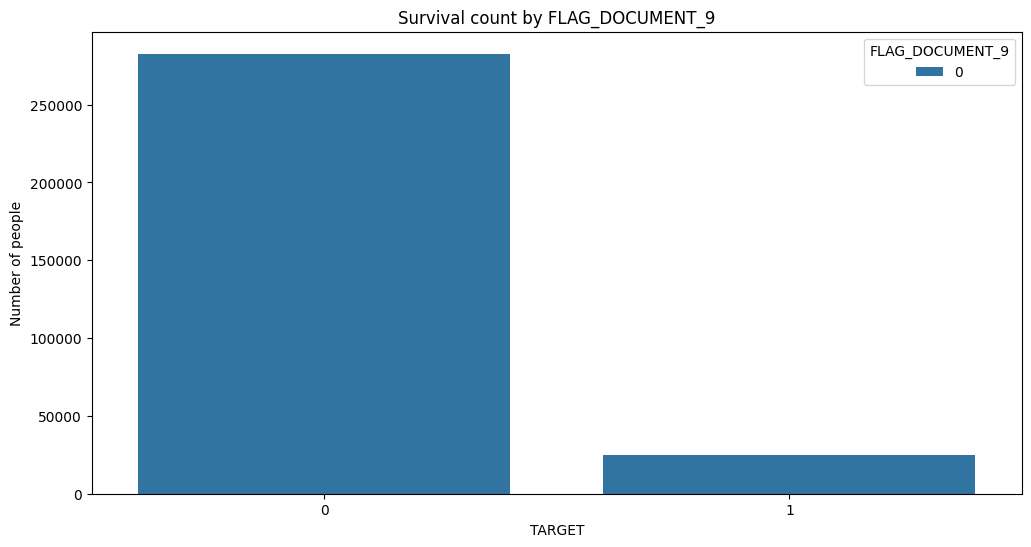

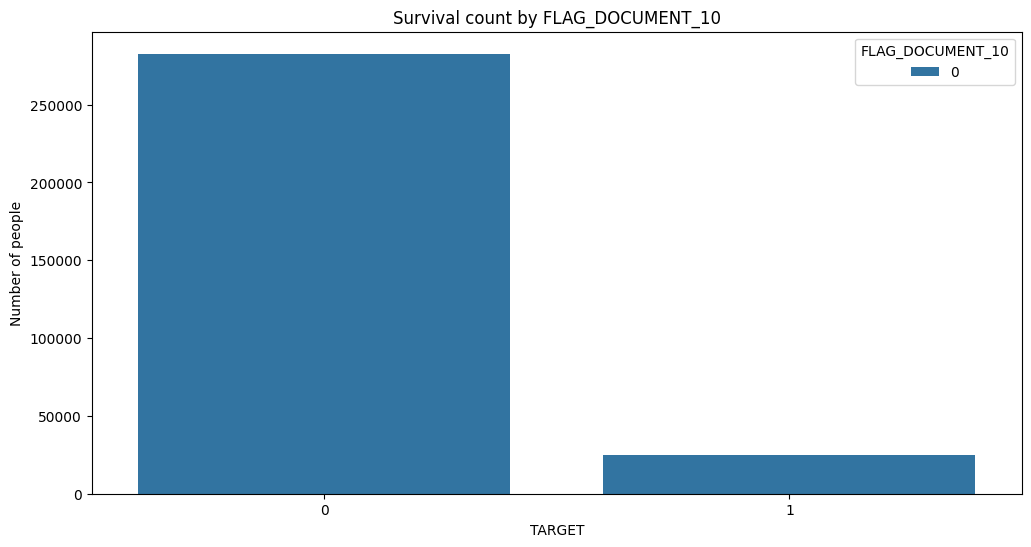

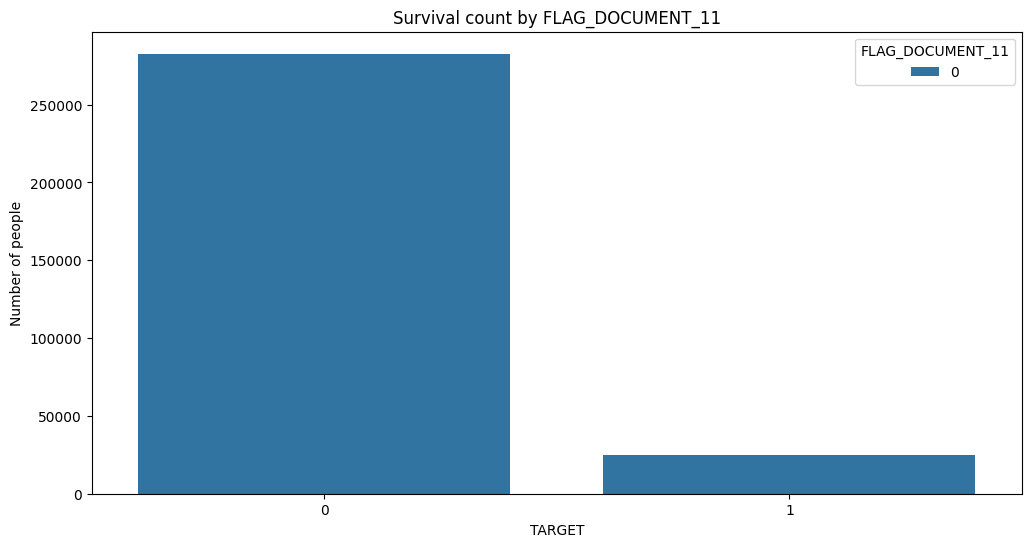

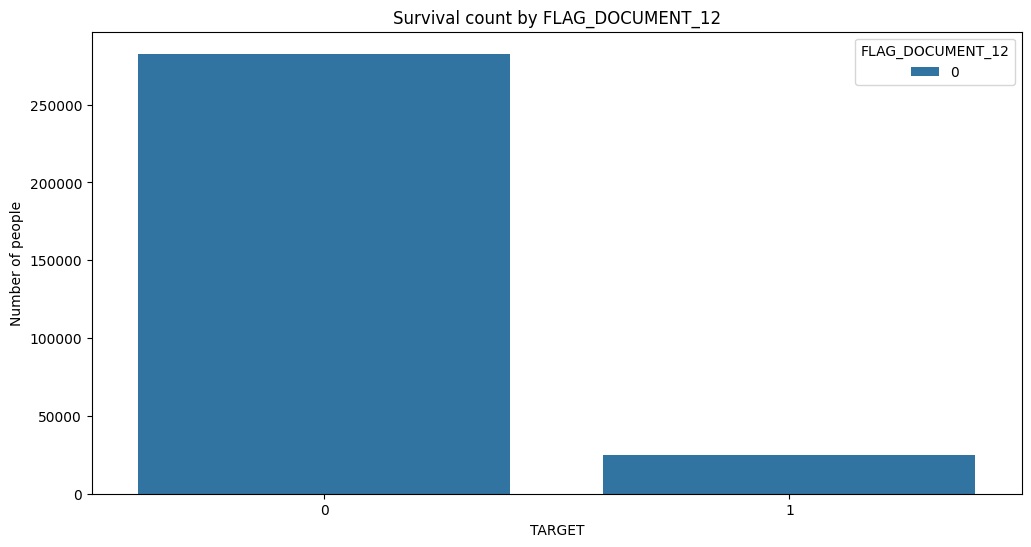

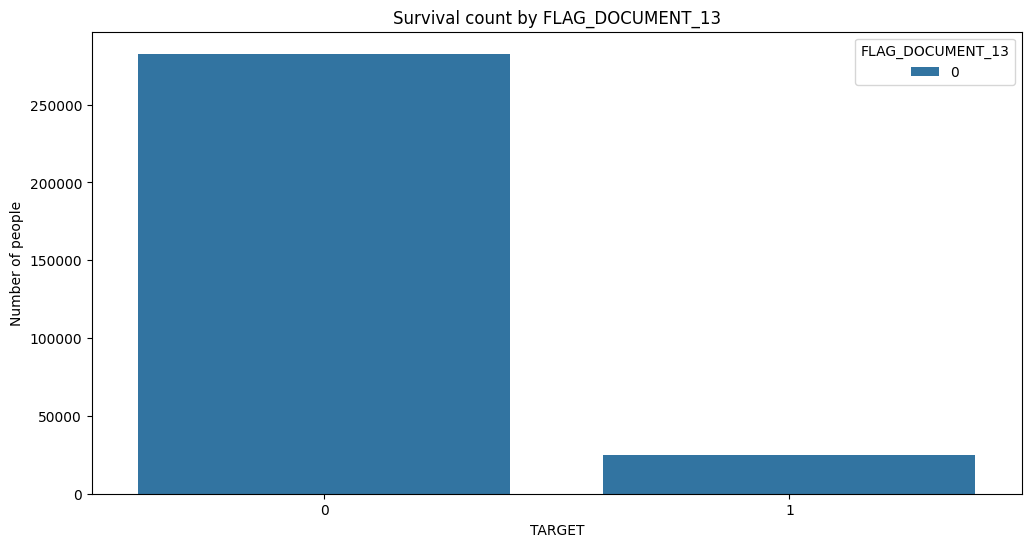

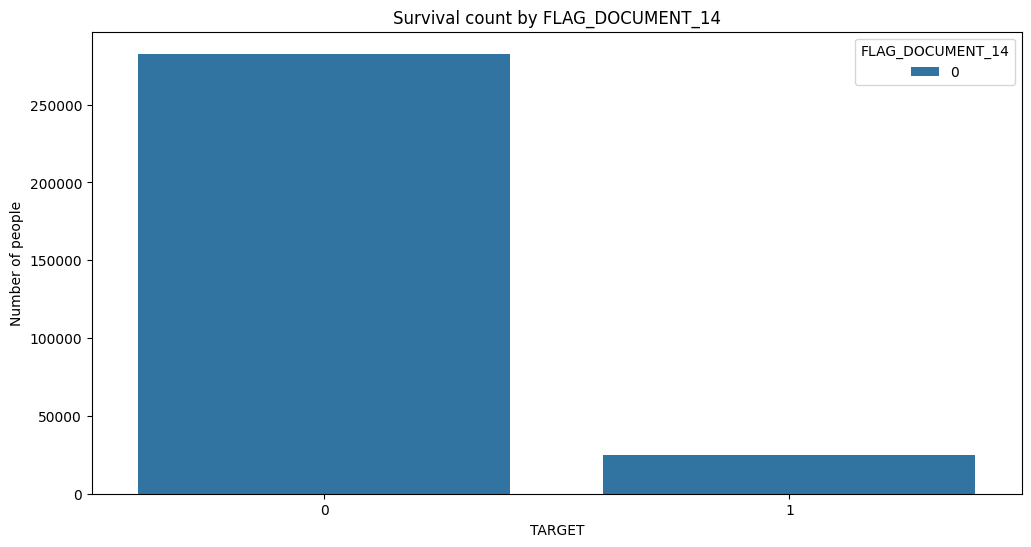

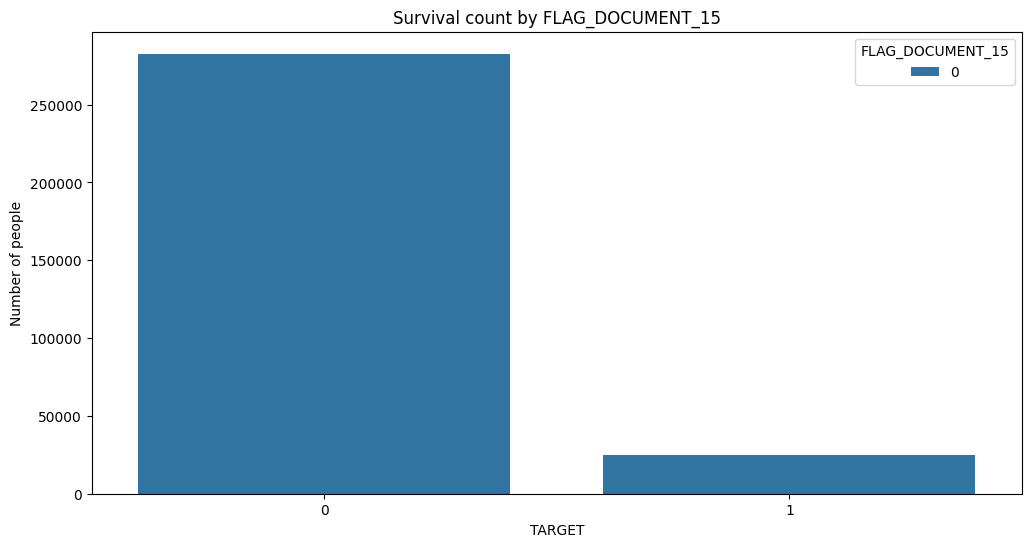

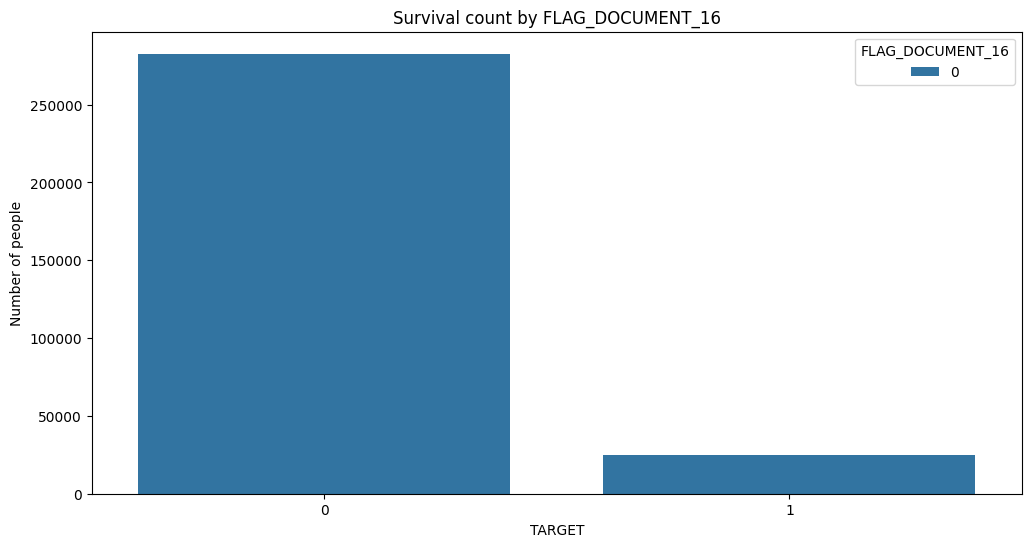

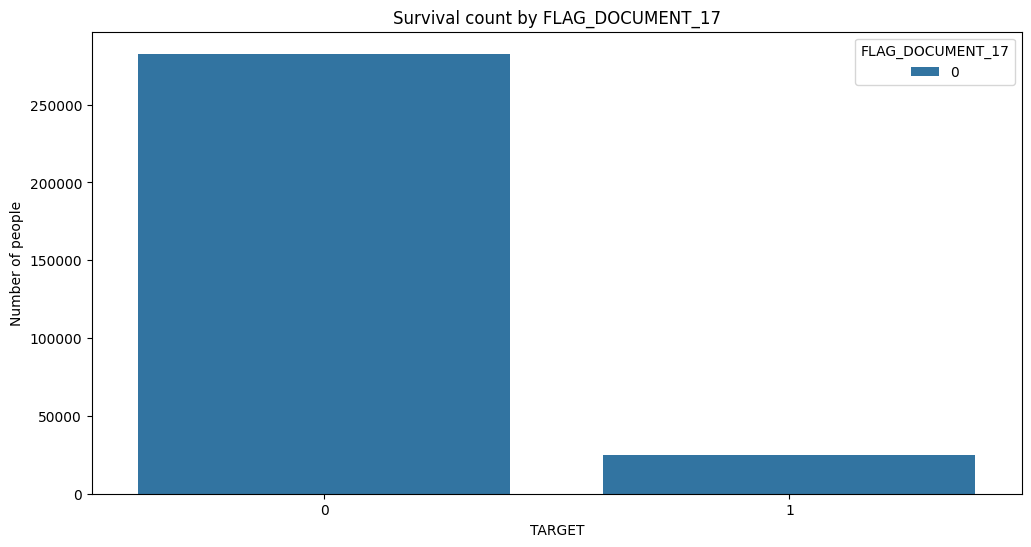

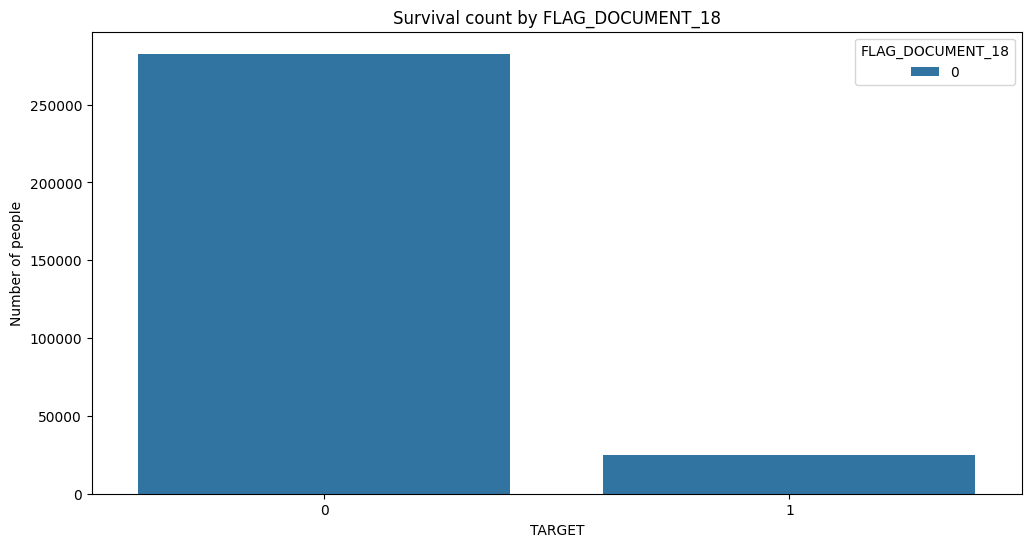

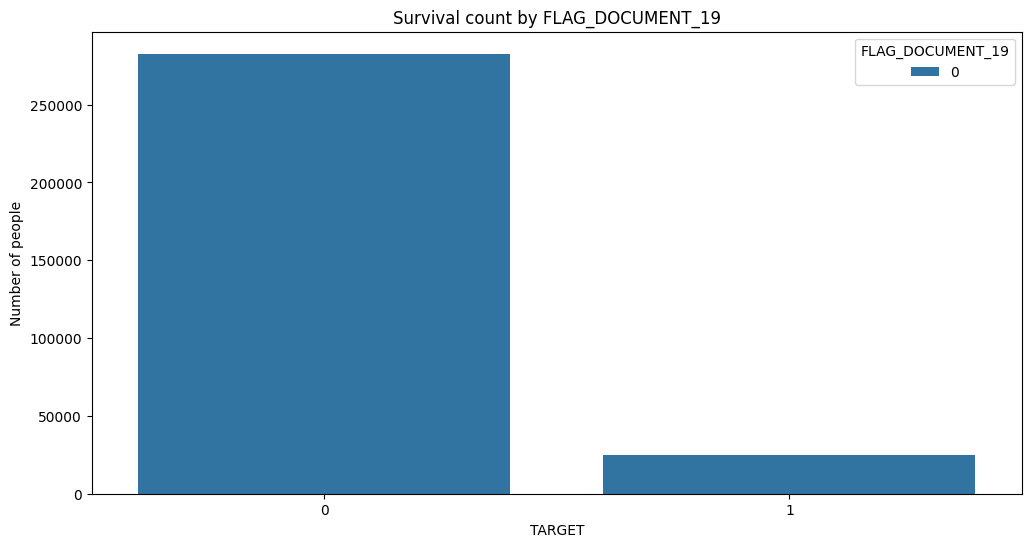

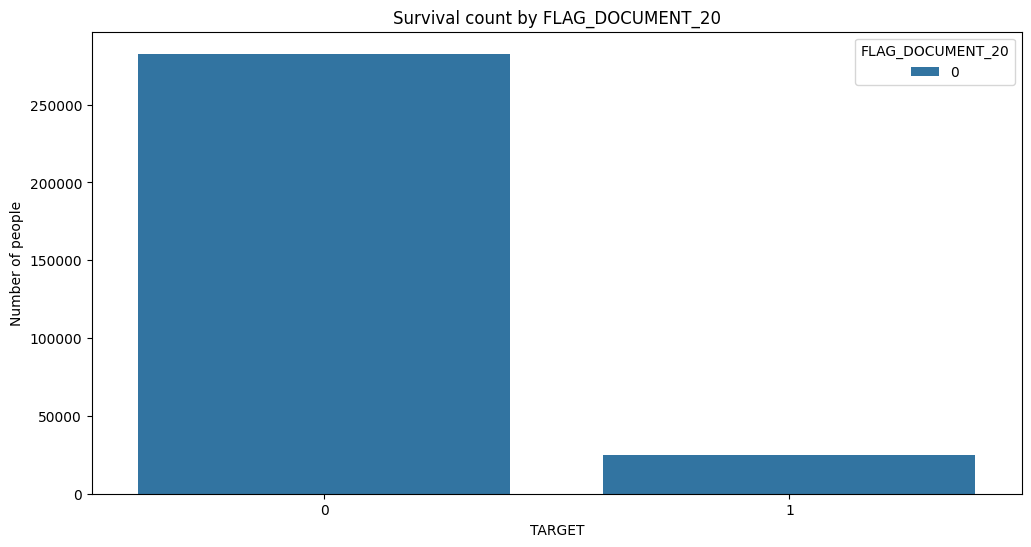

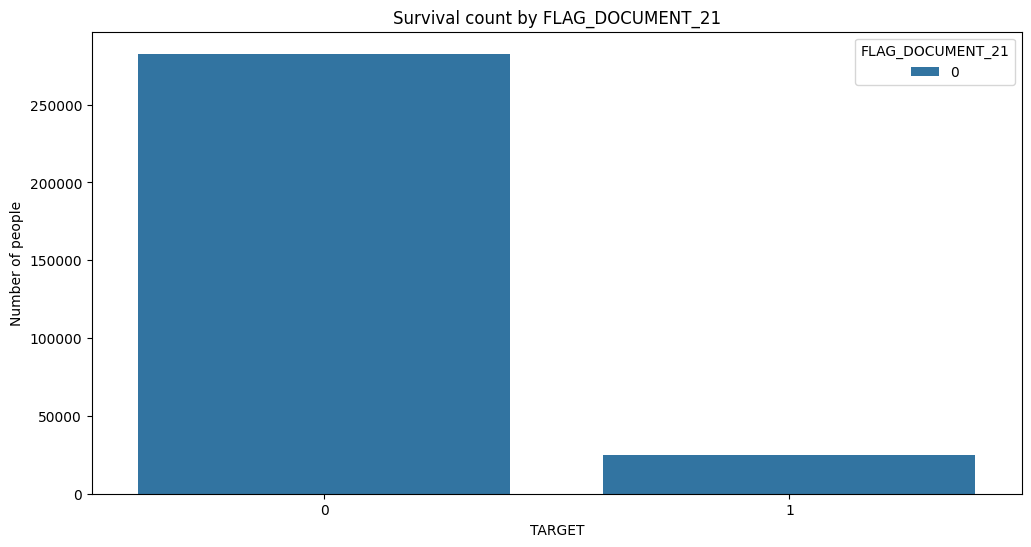

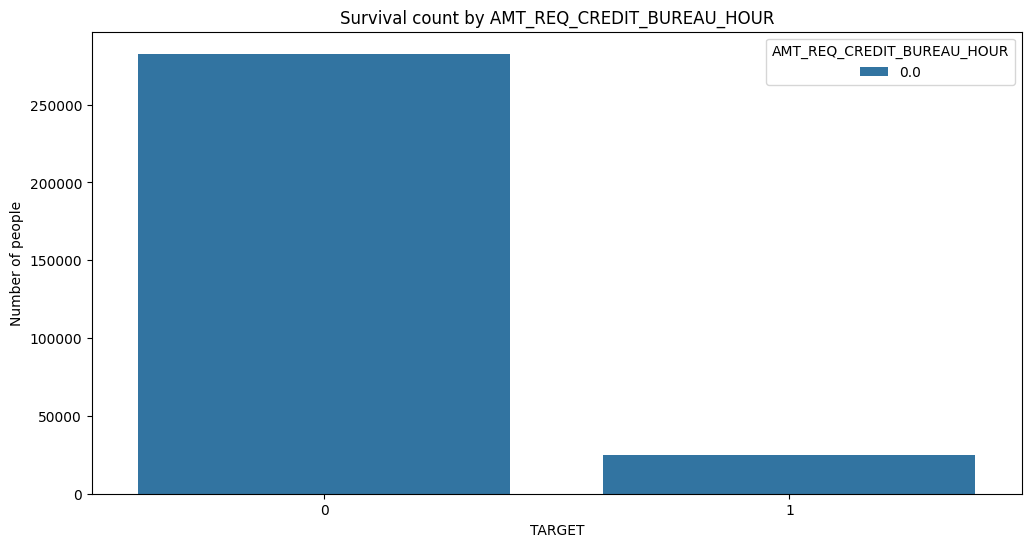

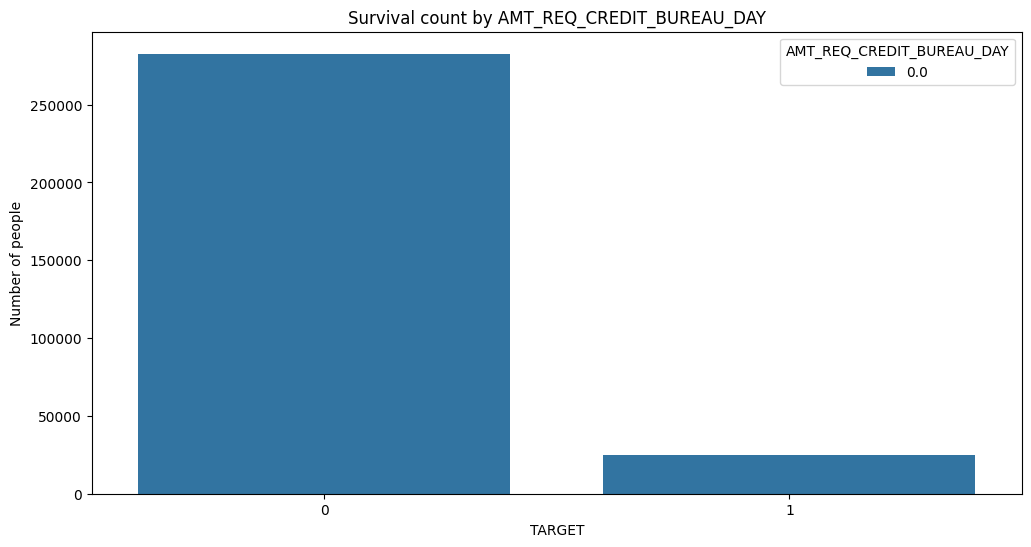

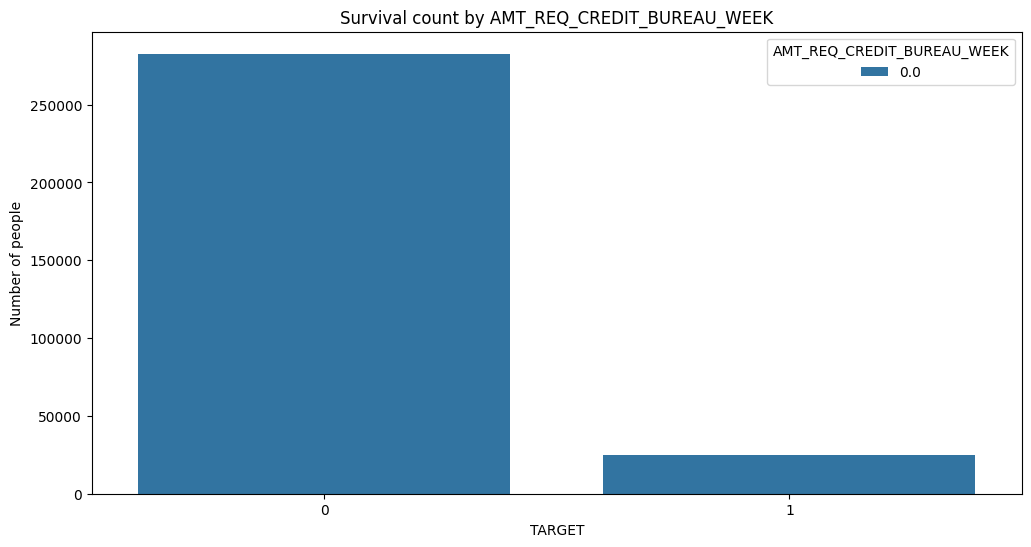

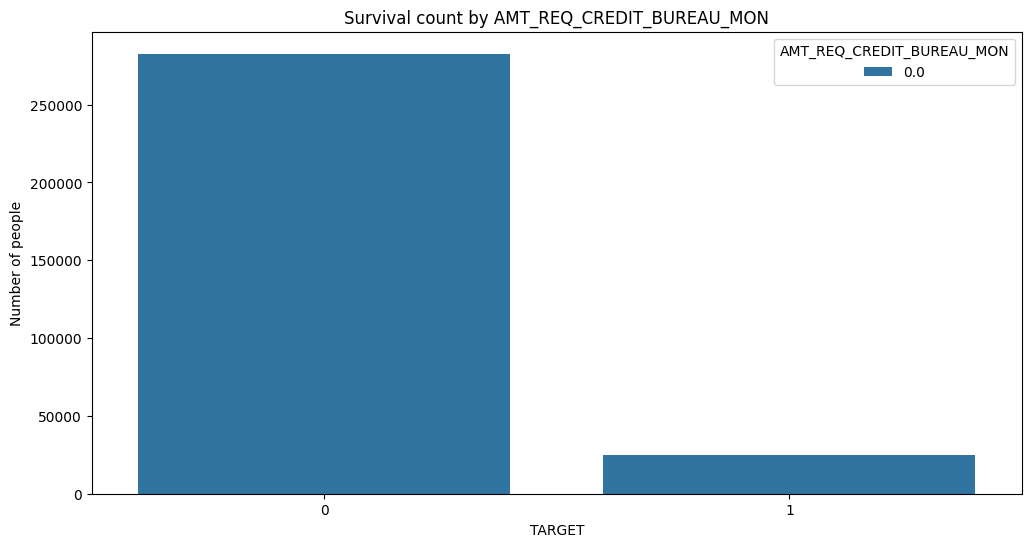

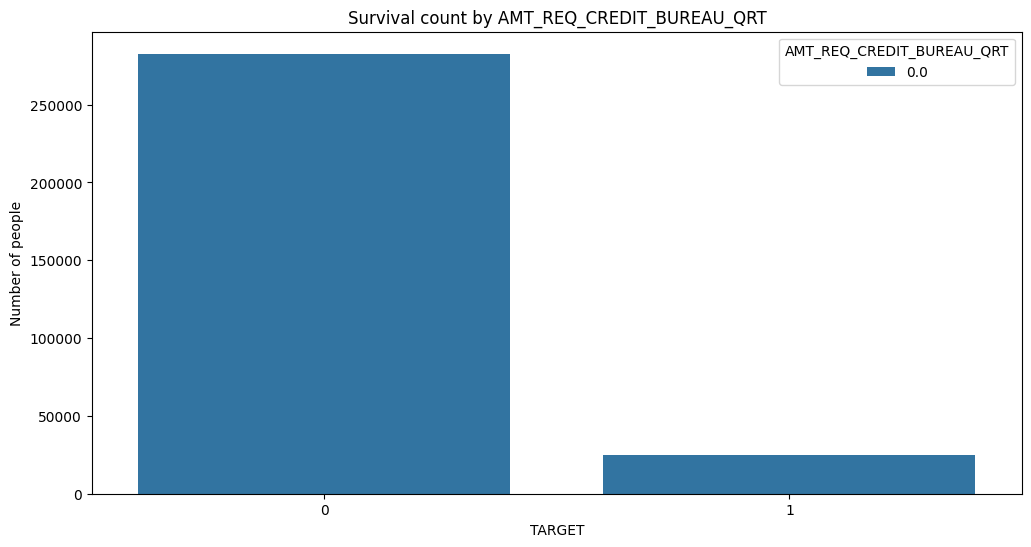

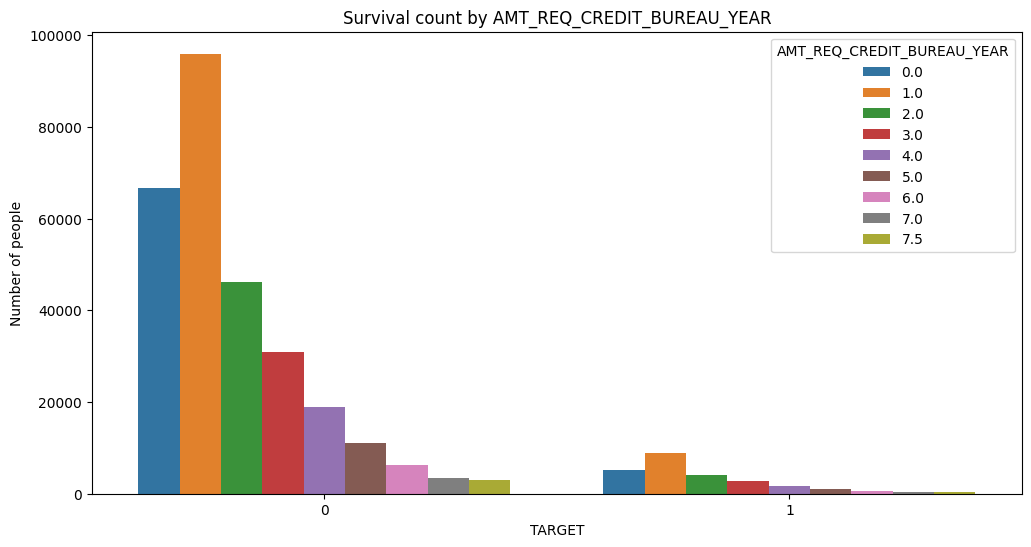

In [19]:
over_column_name = list()

for i in num_cols:
    if (len(df_train[i].value_counts())<20):
        count_plot(df_train, target, i)
    elif (len(df_train[i].value_counts())>20):
        over_column_name.append(i)

In [20]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [23]:
test_col = []
delete_train = []

for i in df_test.columns:
    test_col.append(i)
for j in df_train.columns:
    if j not in test_col:
        delete_train.append(j)
delete_train.remove(target)

In [24]:
train_col = []
delete_test = []

for i in df_train.columns:
    train_col.append(i)
for j in df_test.columns:
    if j not in train_col:
        delete_test.append(j)

In [25]:
for delete in delete_train:
    df_train = df_train.drop([delete],axis=1)
    
for delete in delete_test:
    df_test = df_test.drop([delete],axis=1)

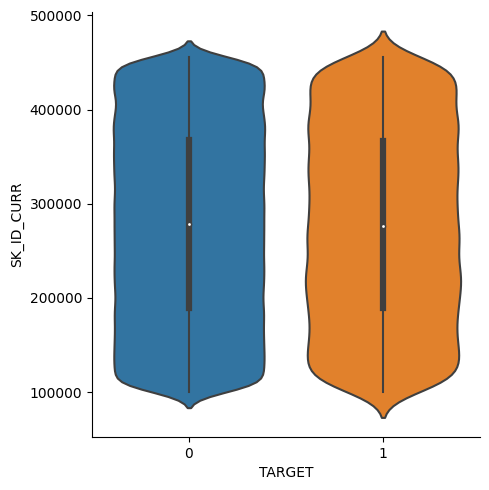

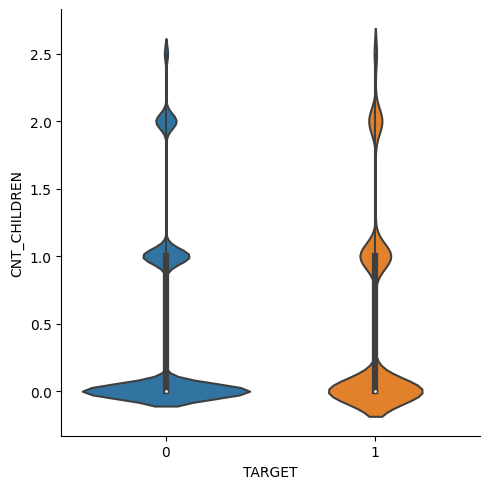

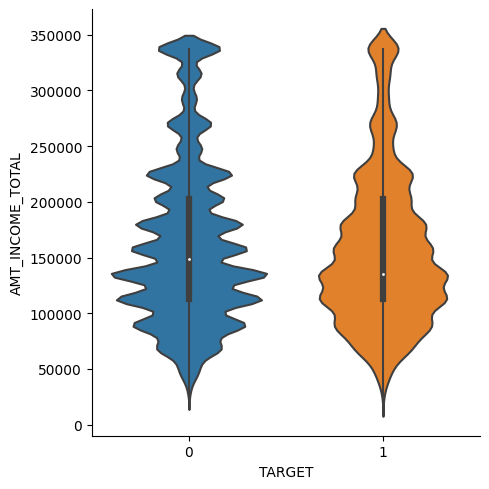

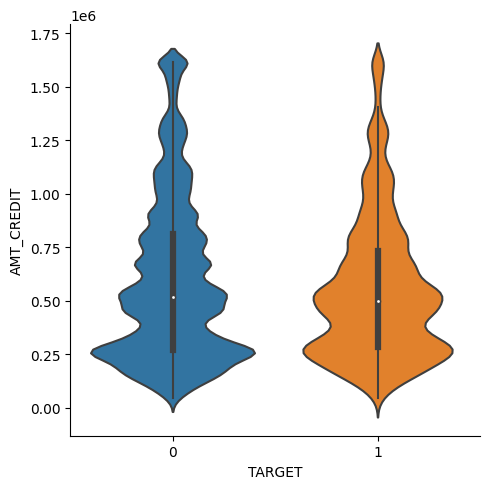

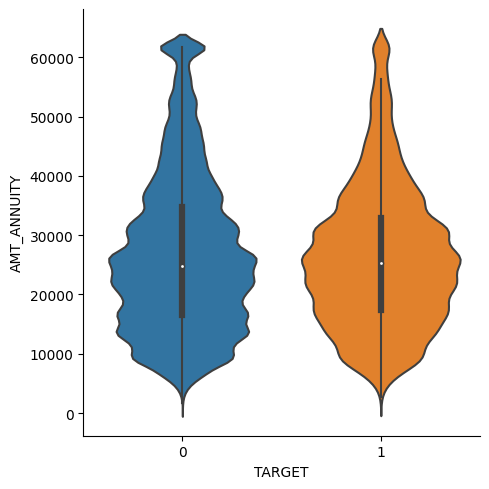

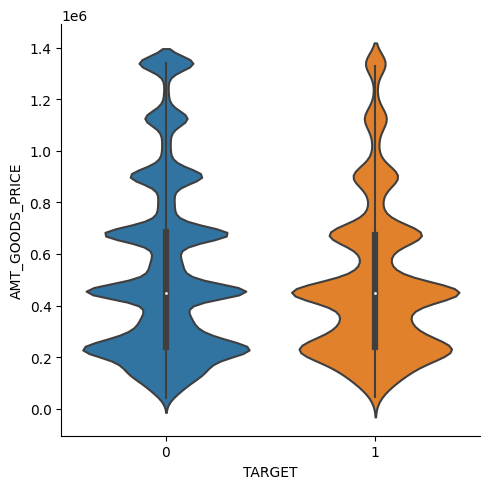

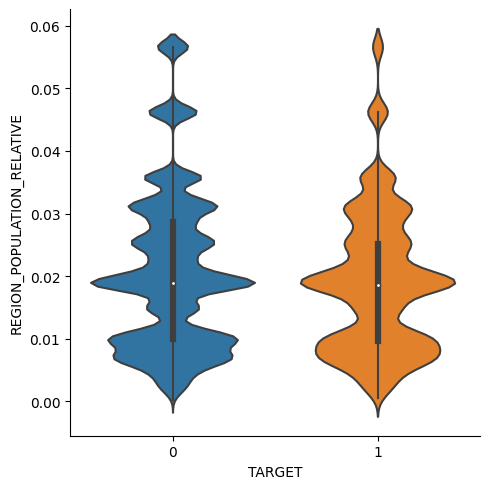

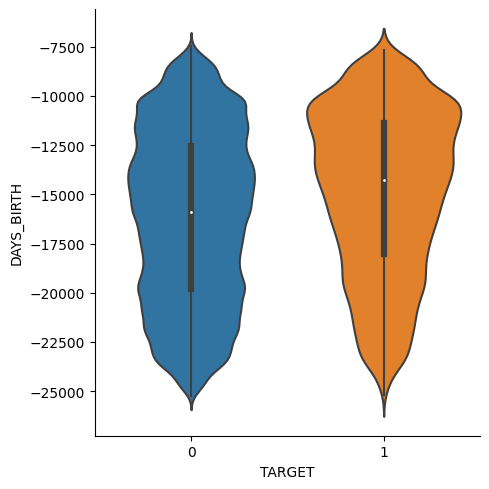

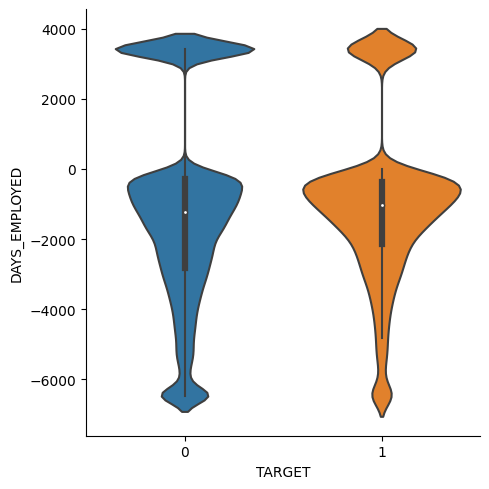

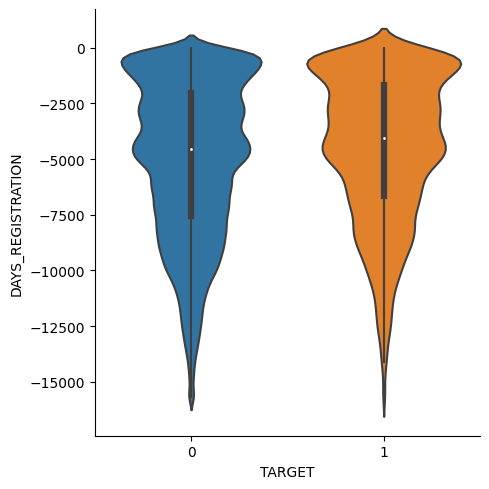

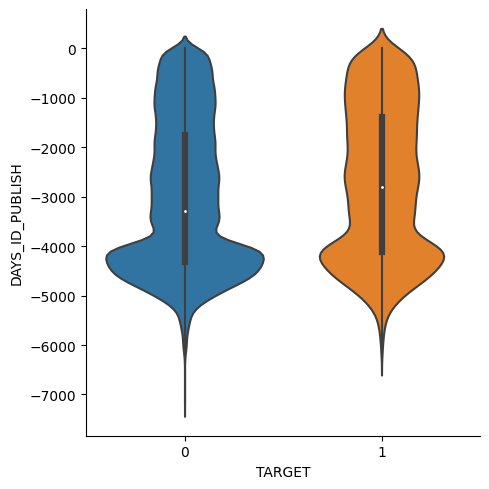

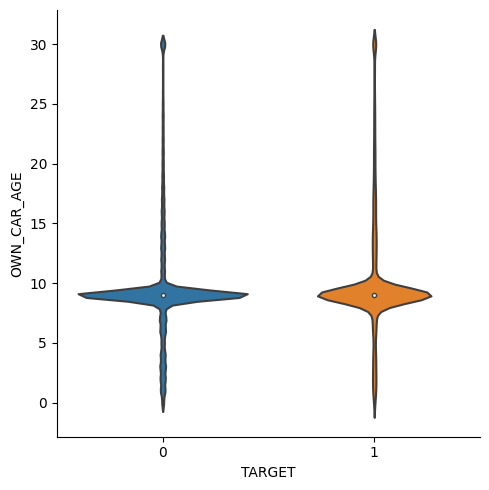

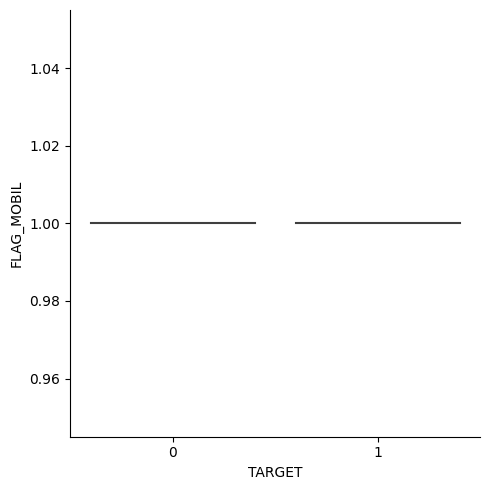

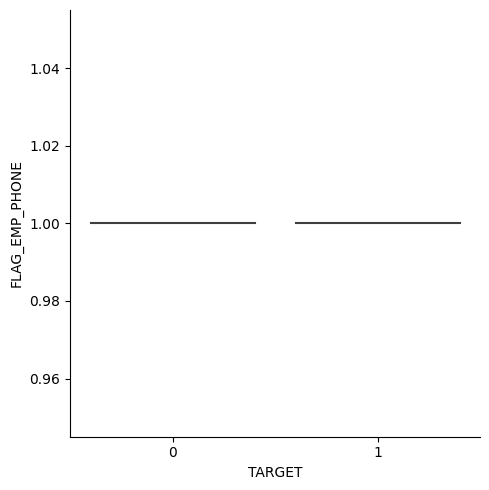

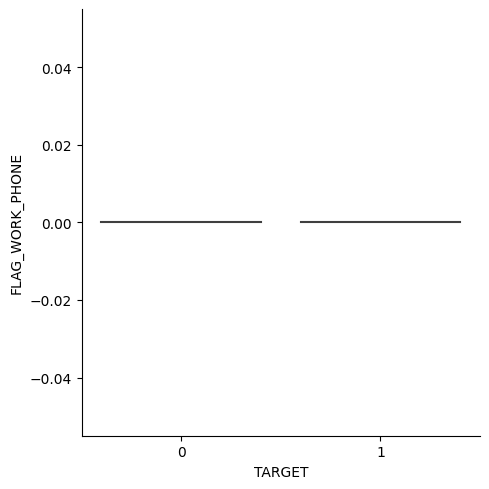

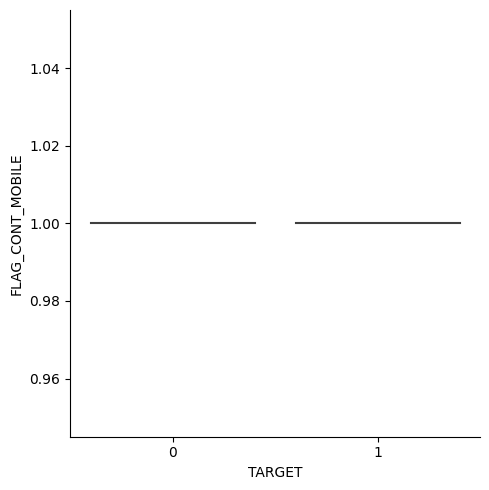

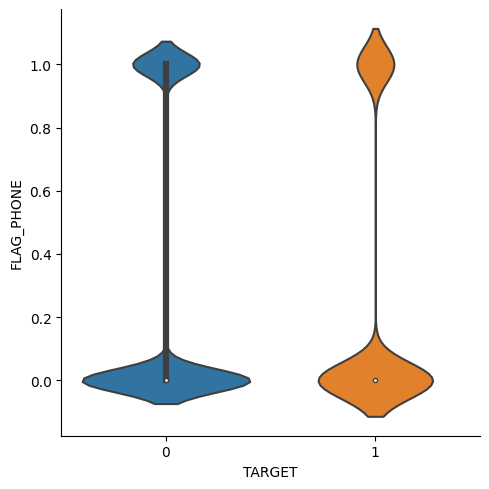

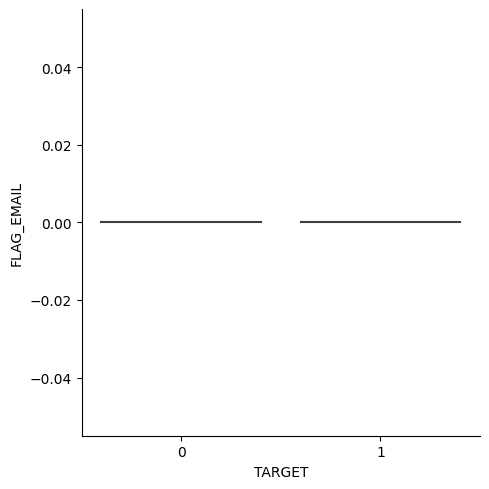

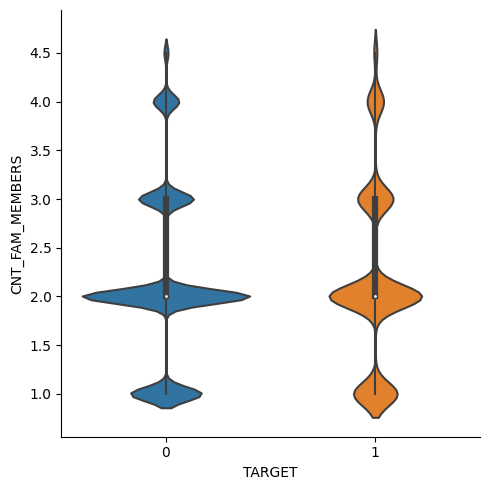

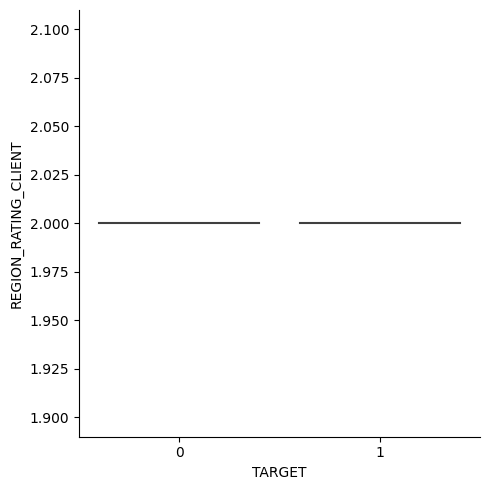

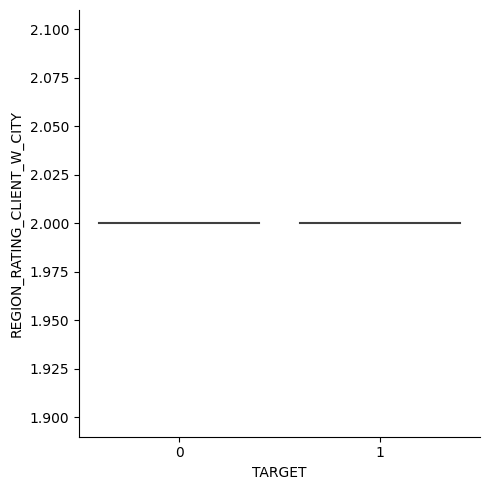

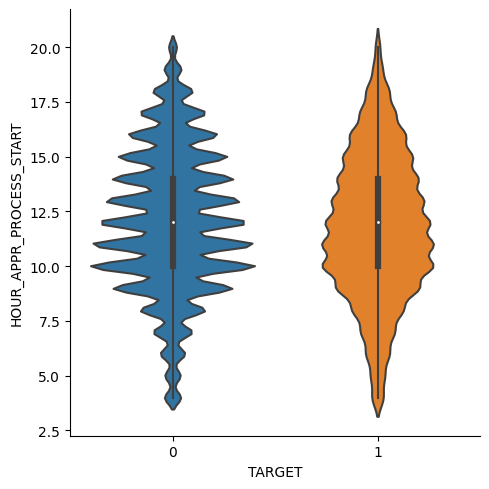

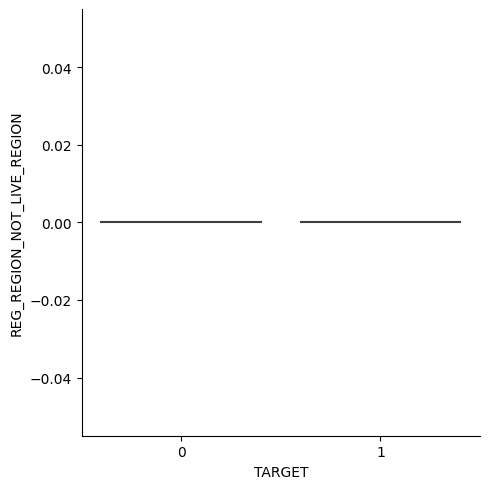

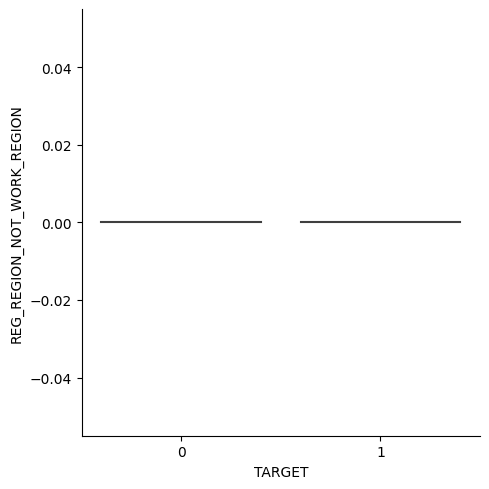

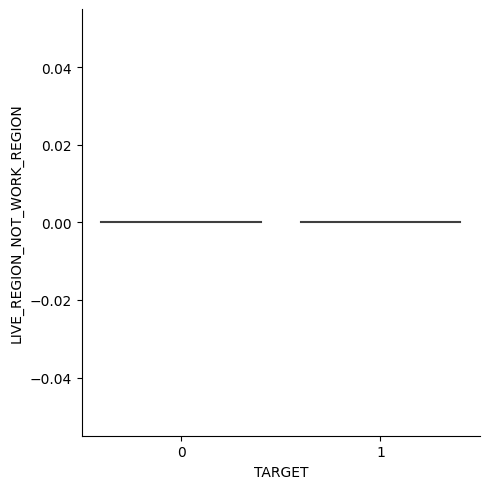

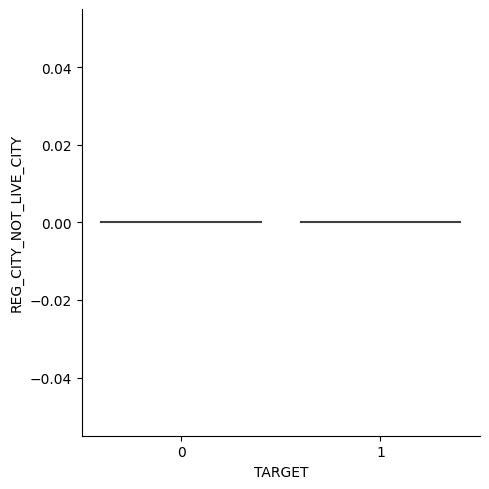

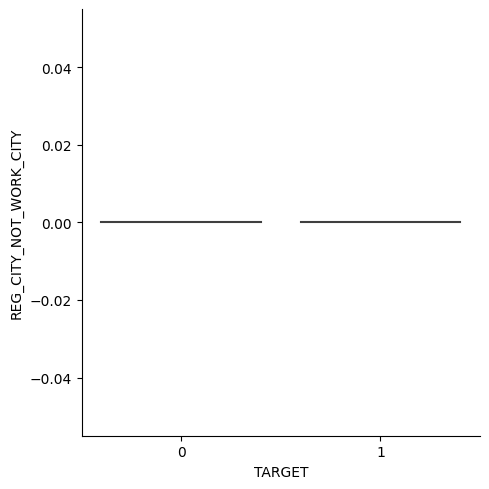

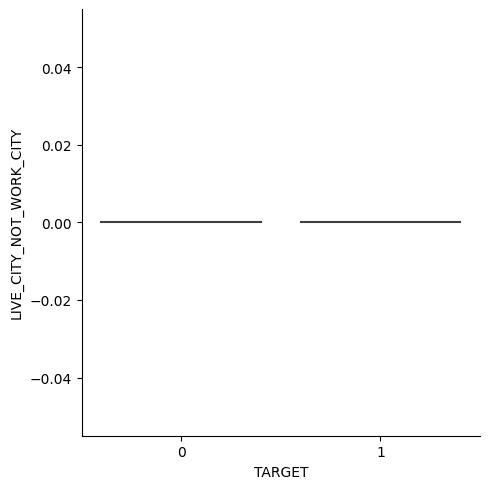

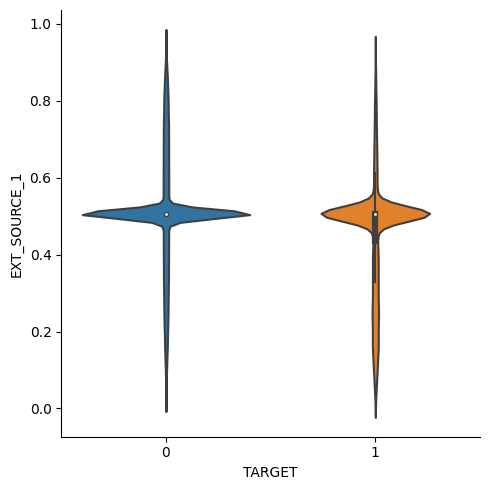

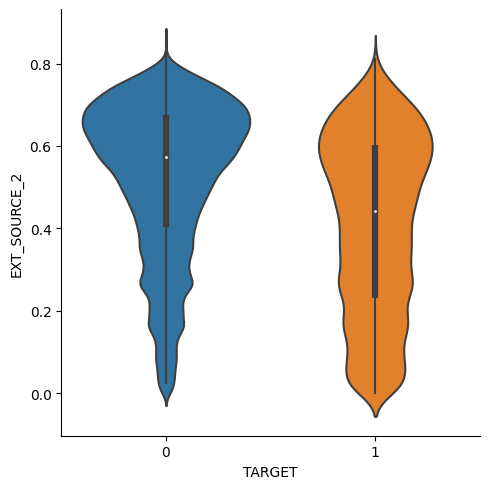

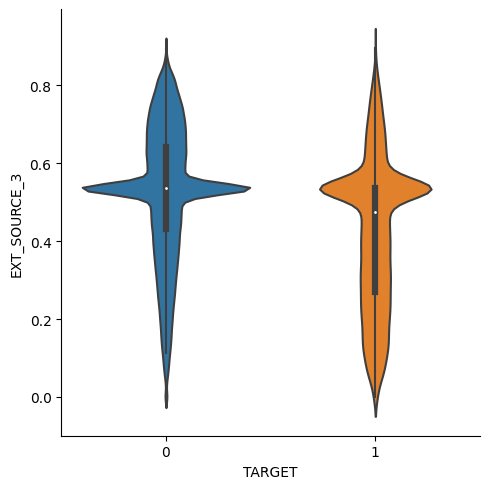

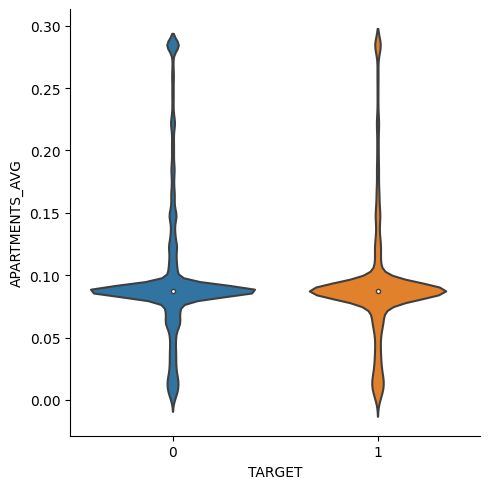

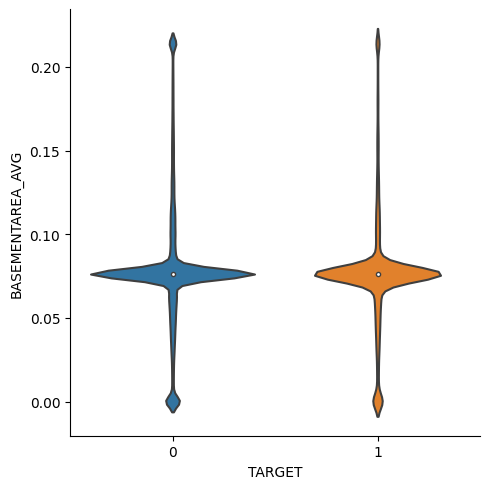

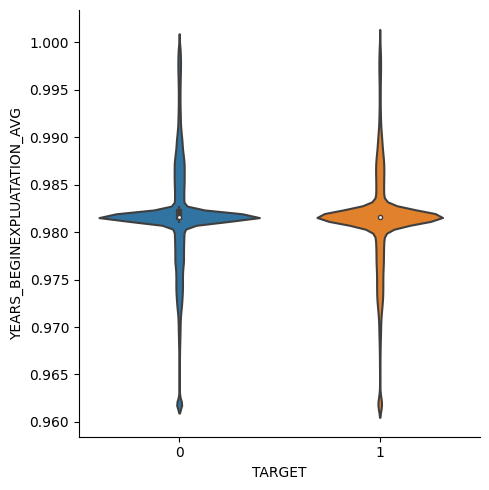

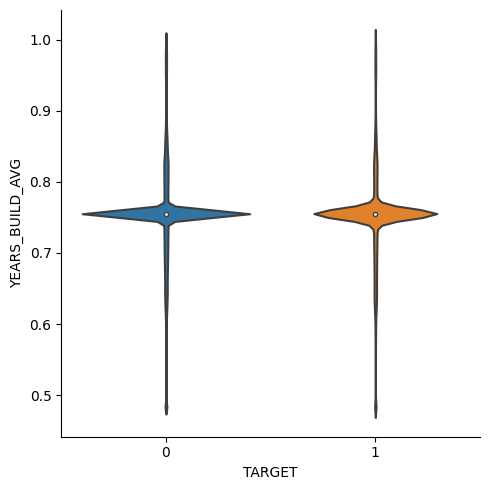

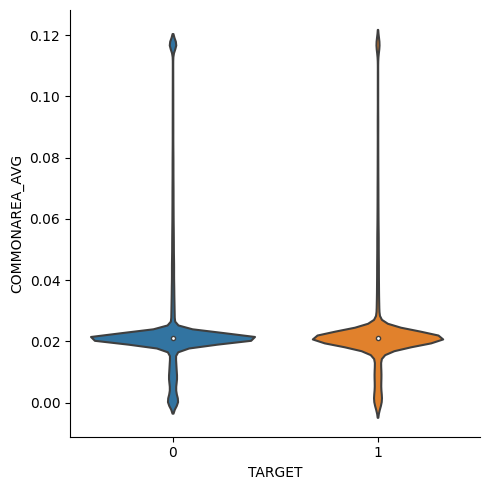

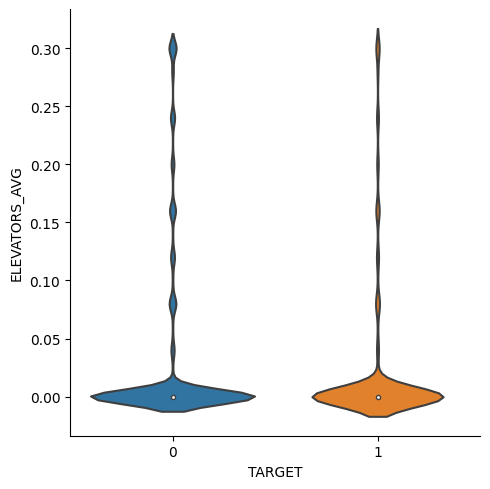

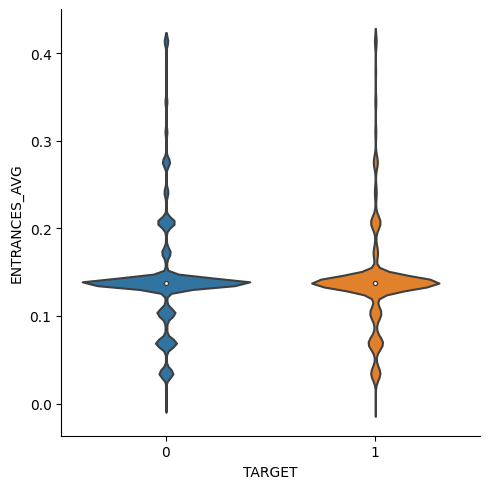

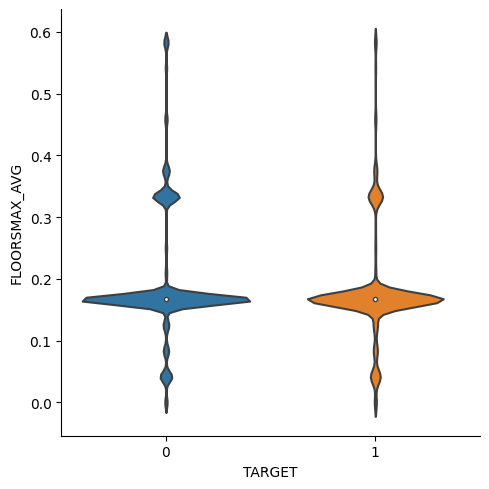

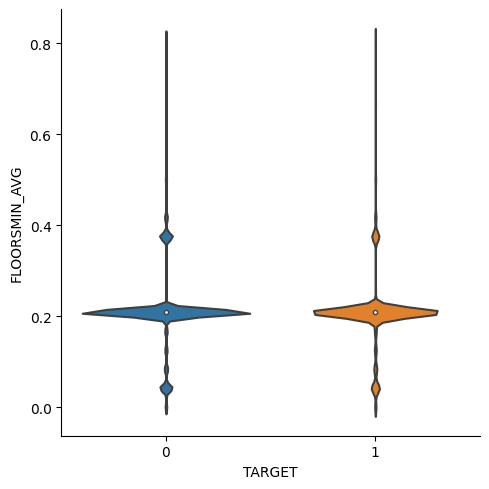

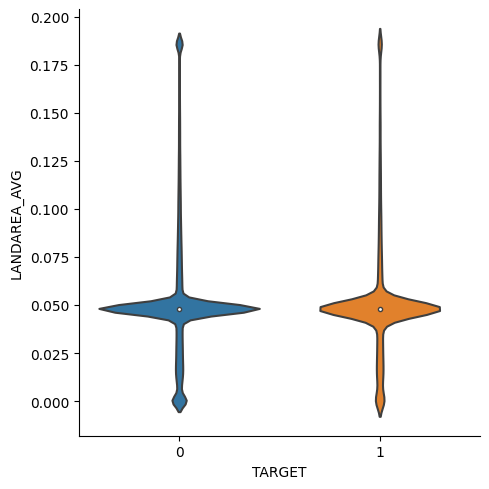

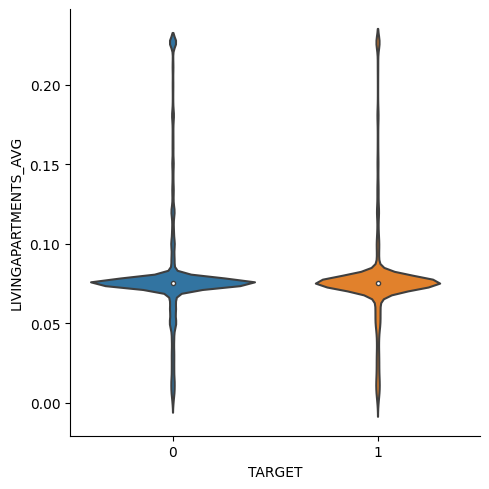

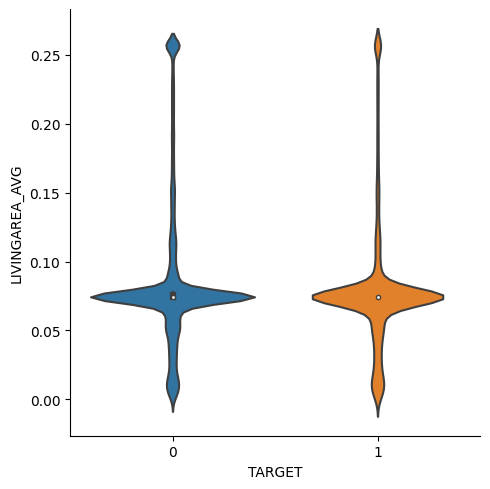

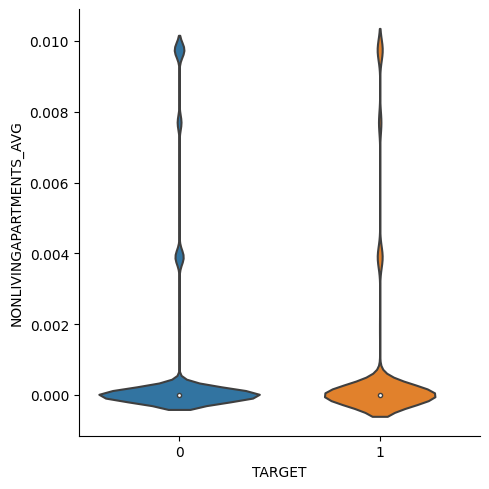

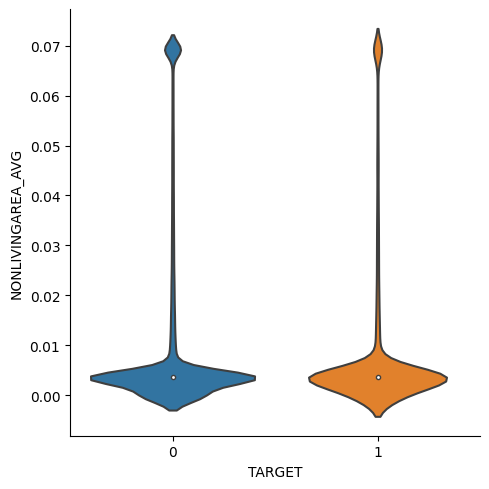

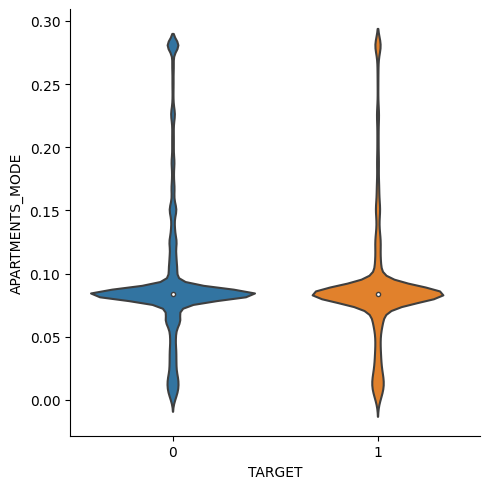

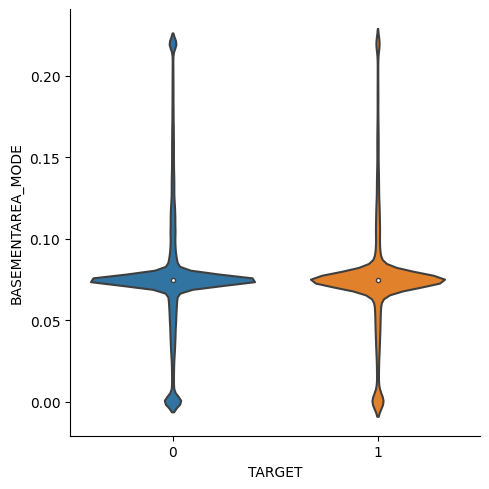

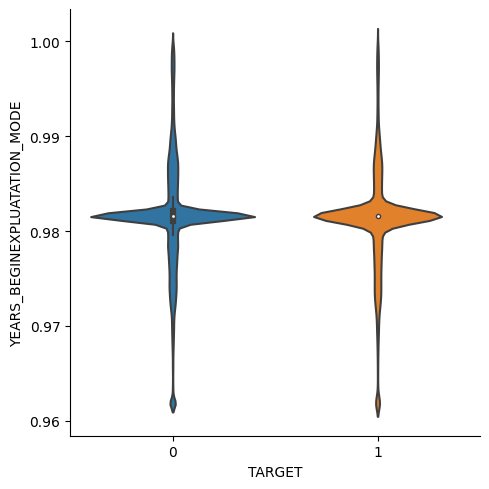

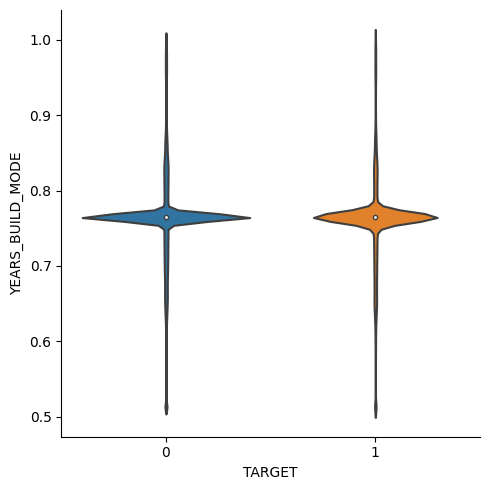

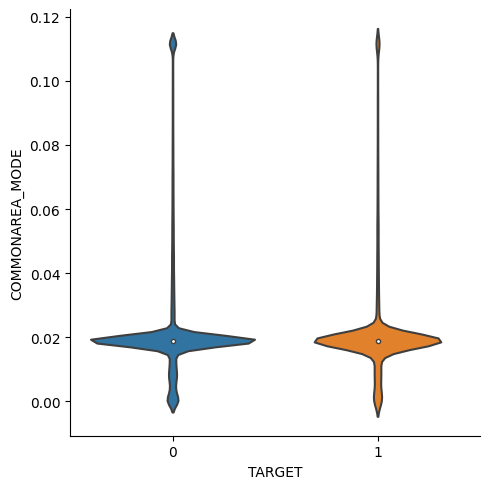

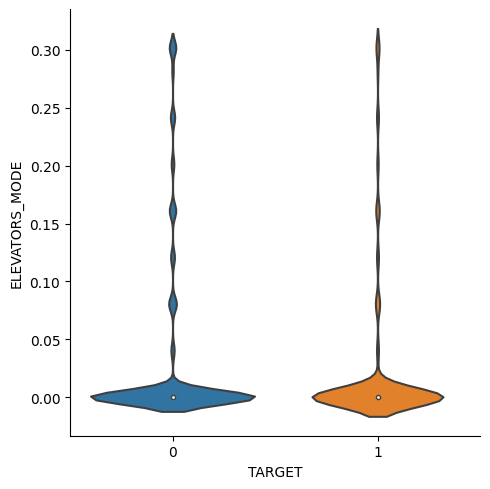

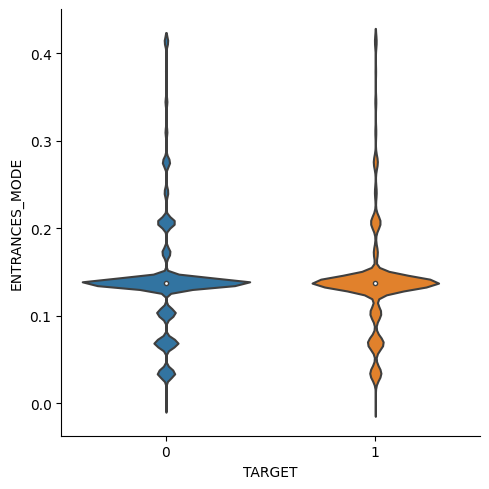

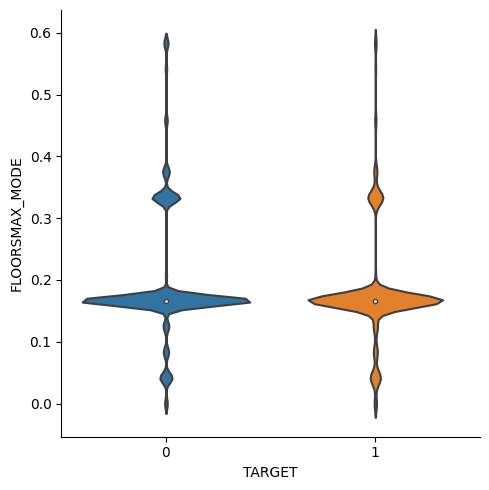

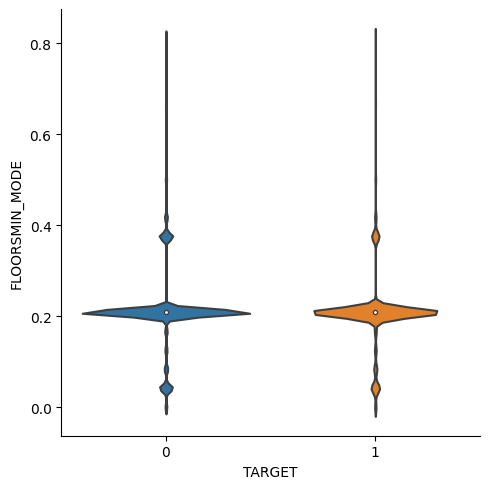

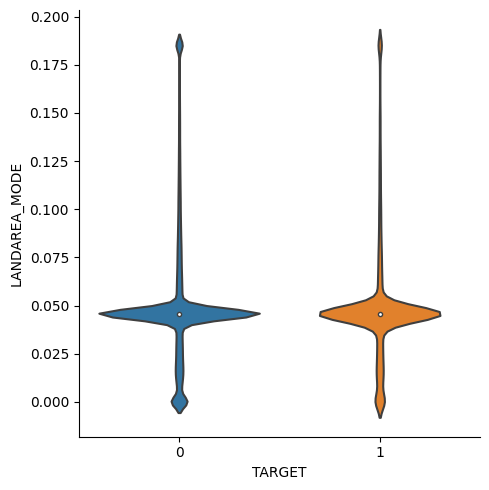

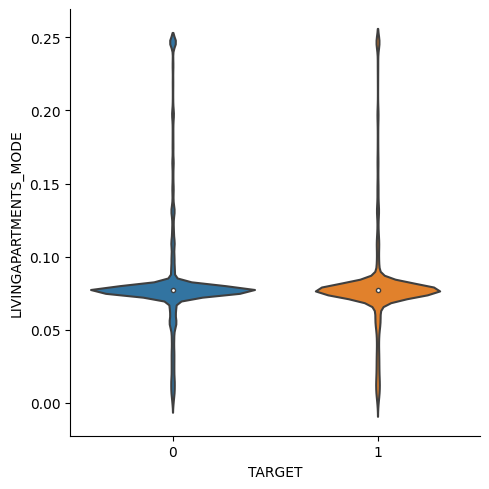

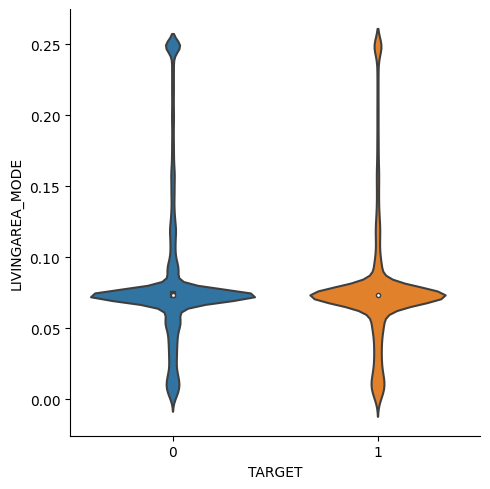

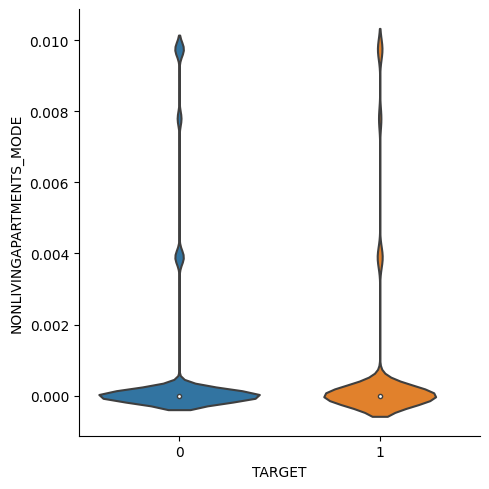

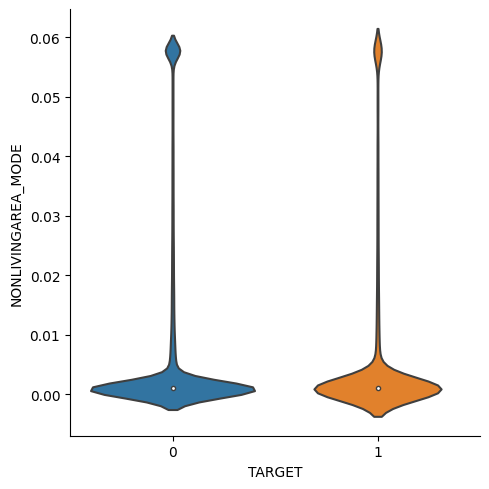

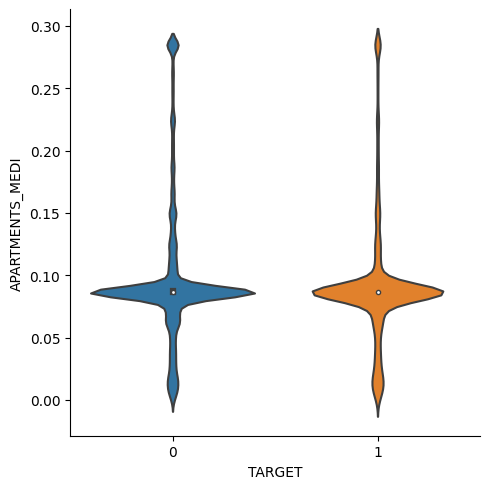

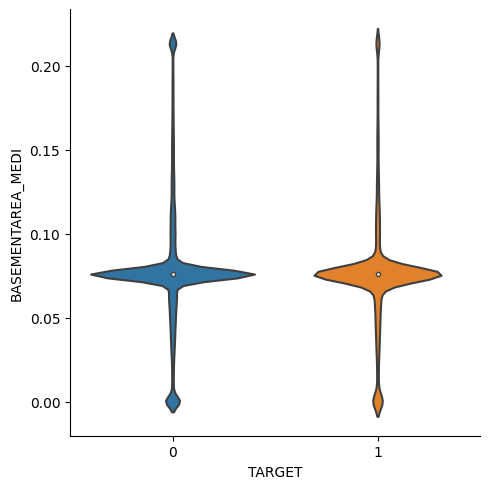

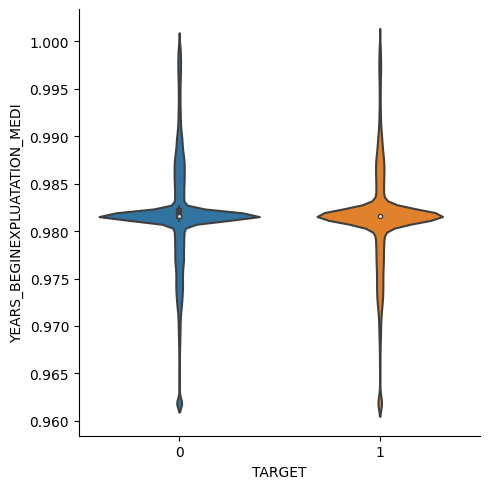

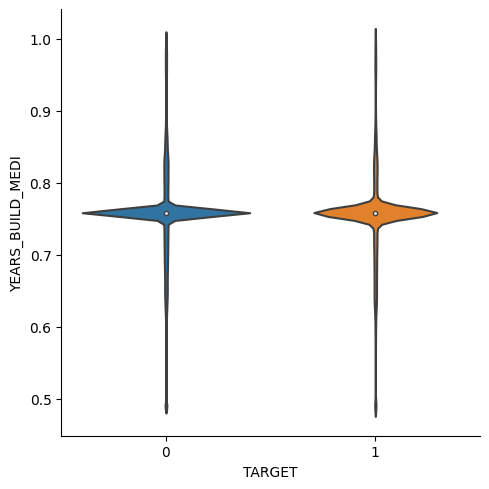

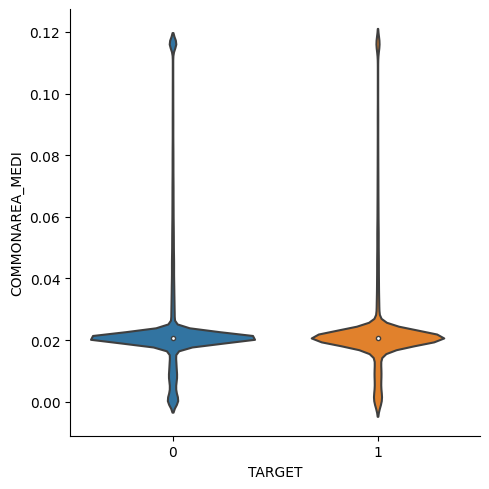

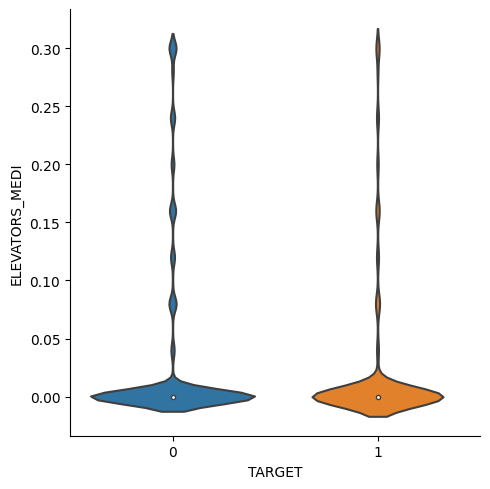

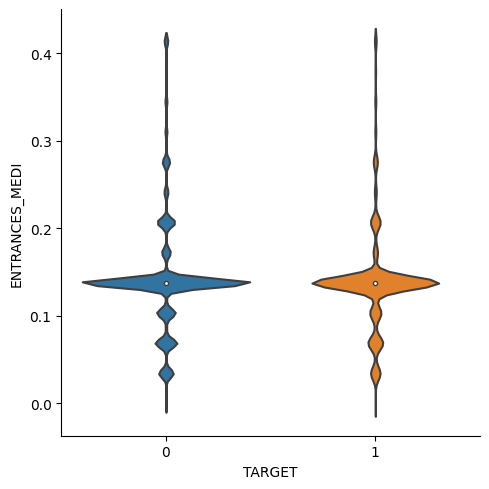

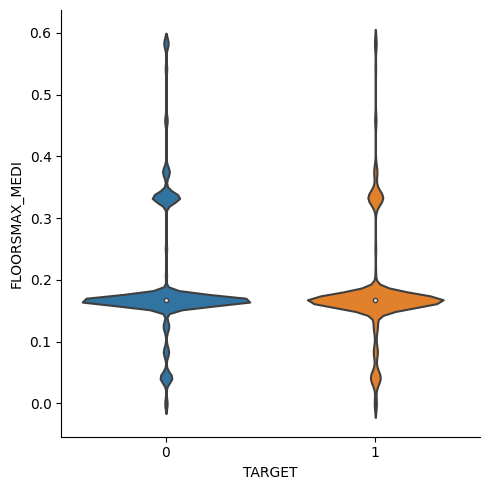

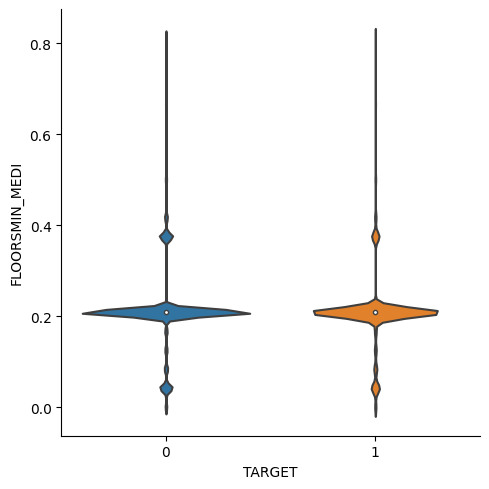

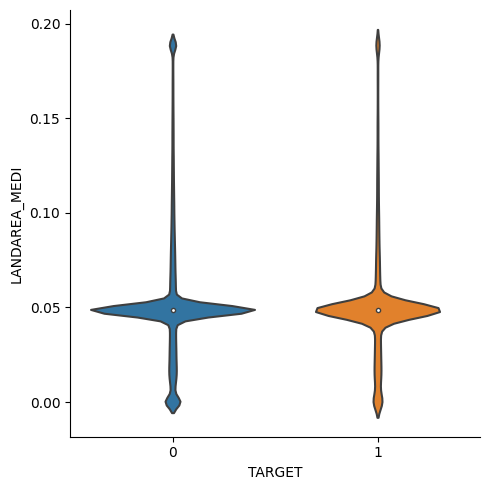

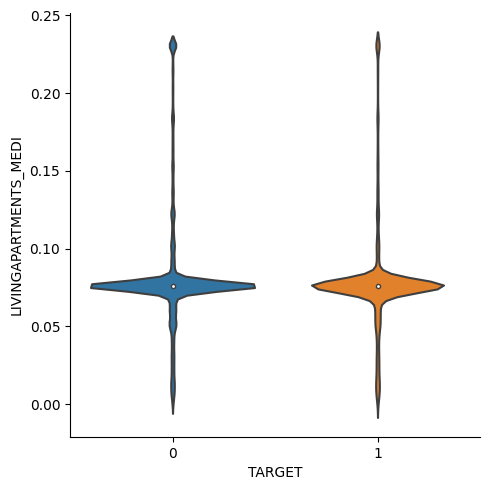

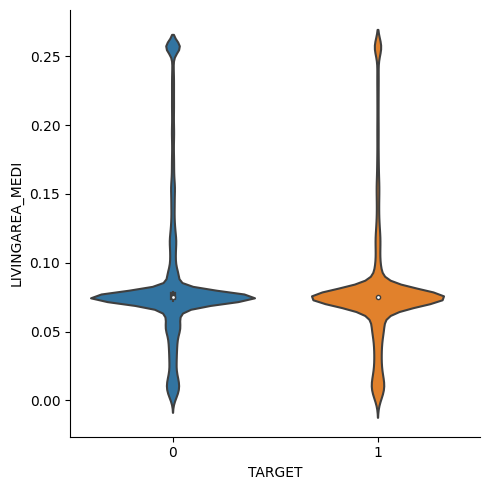

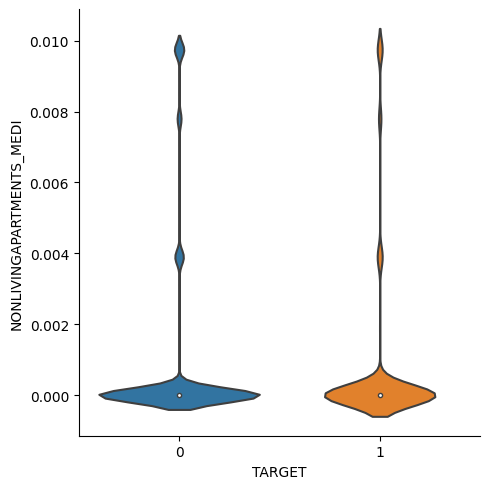

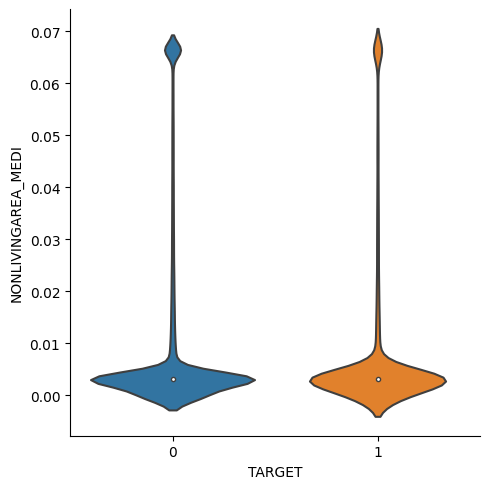

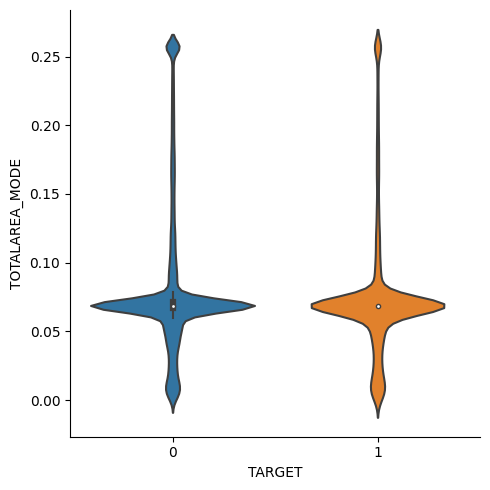

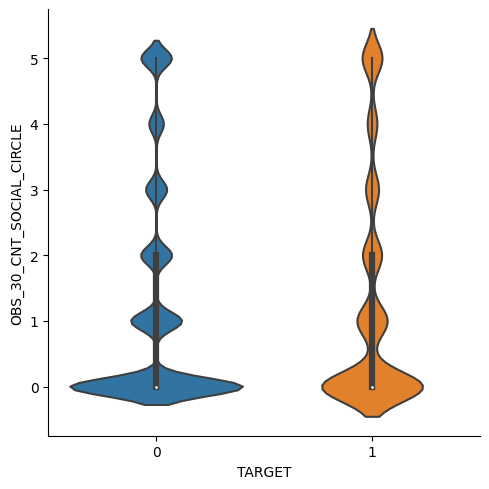

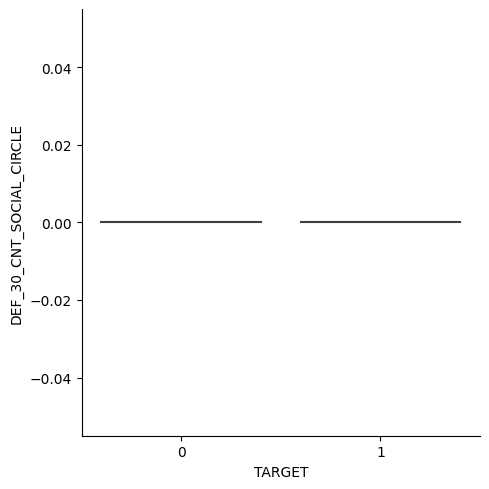

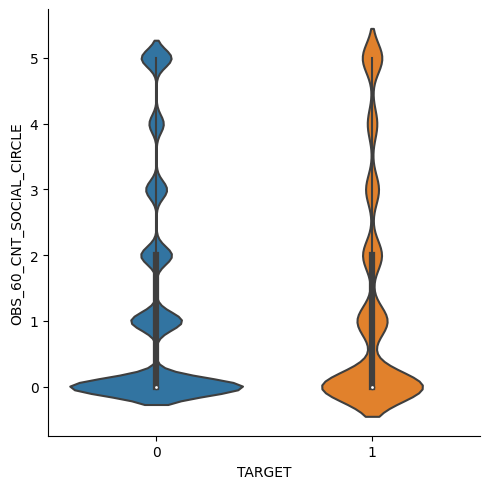

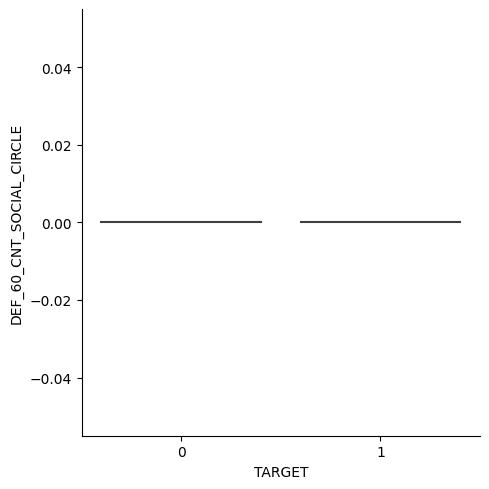

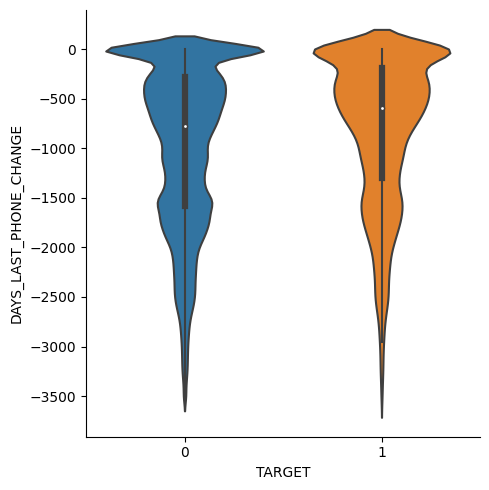

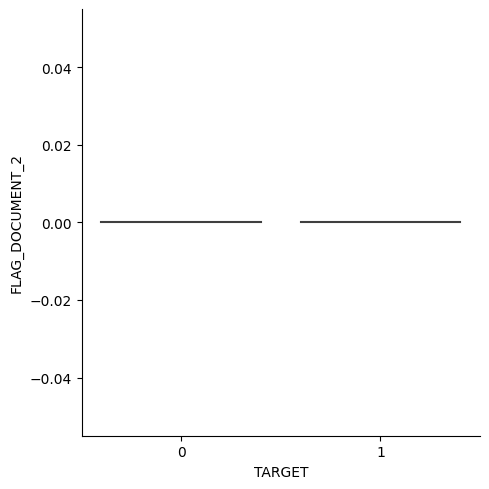

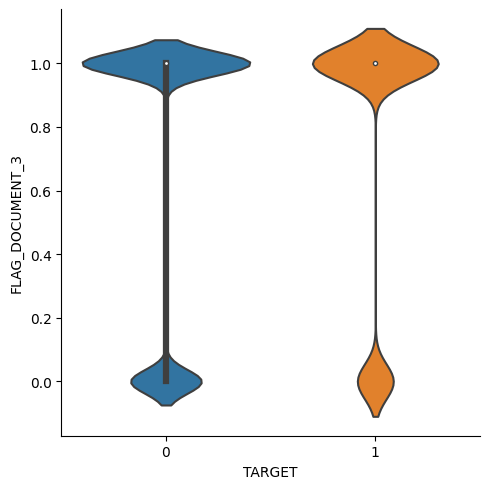

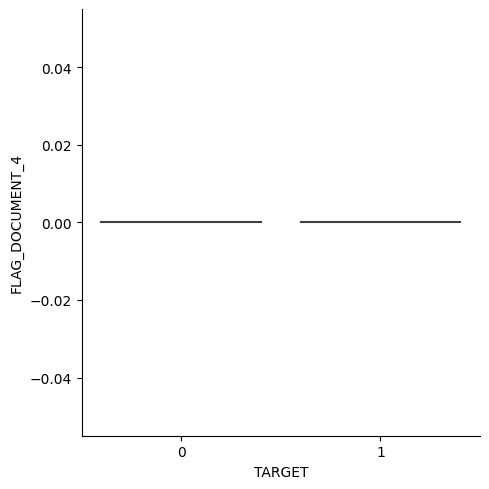

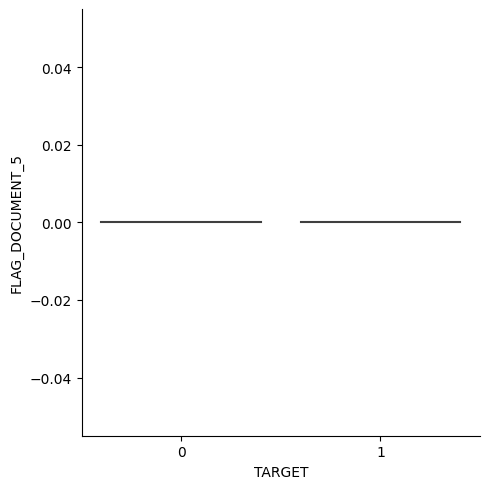

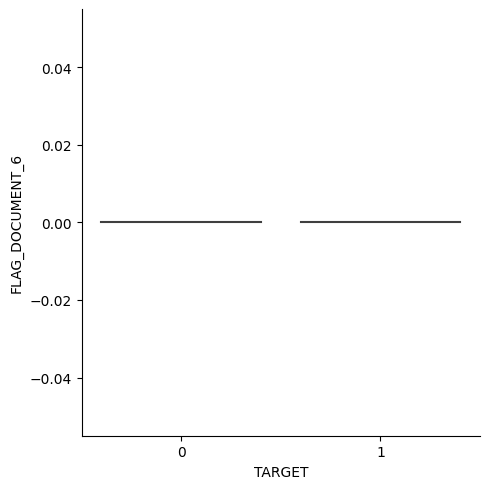

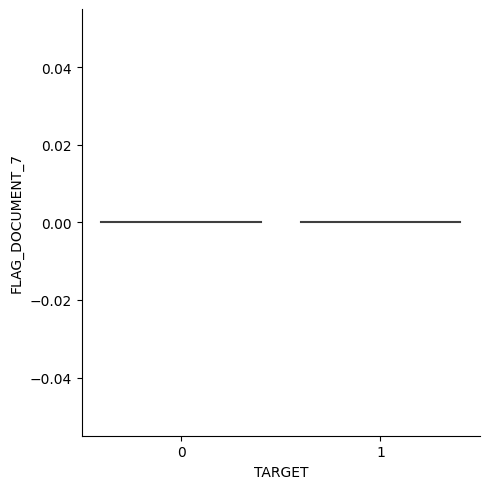

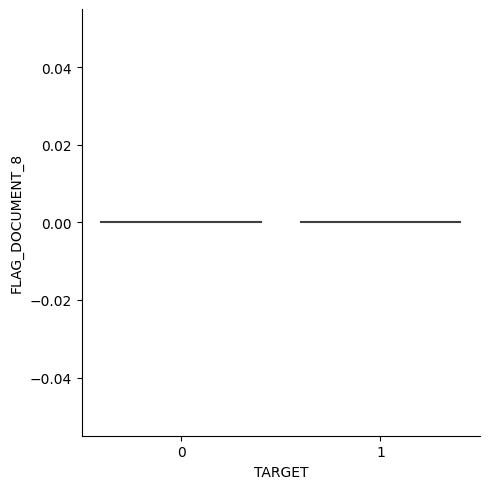

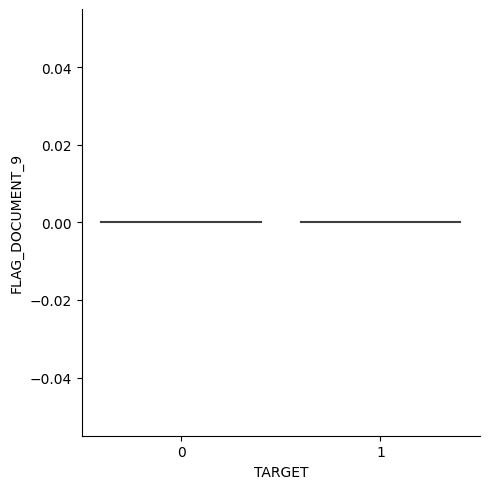

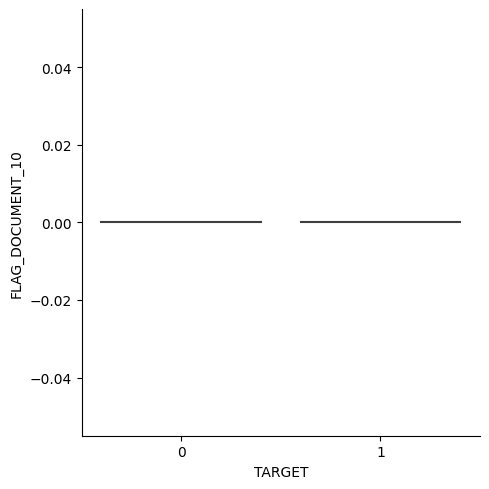

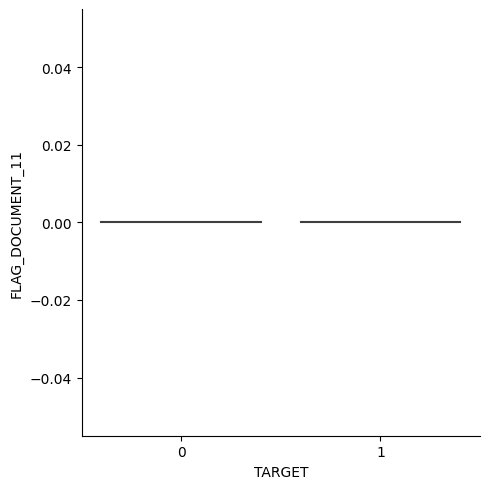

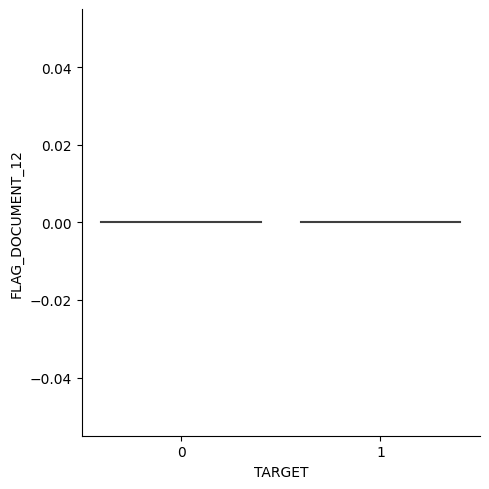

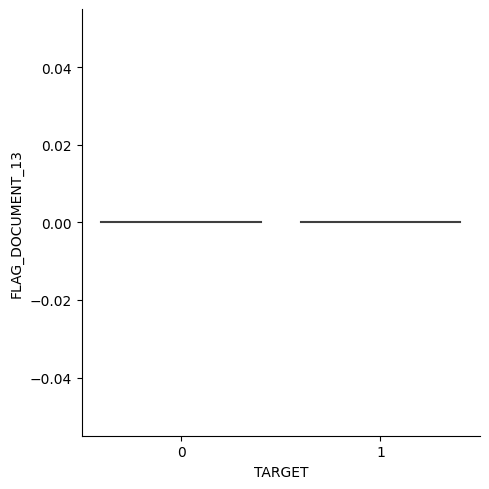

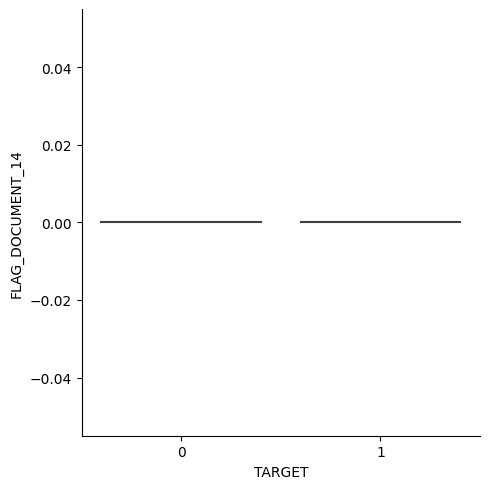

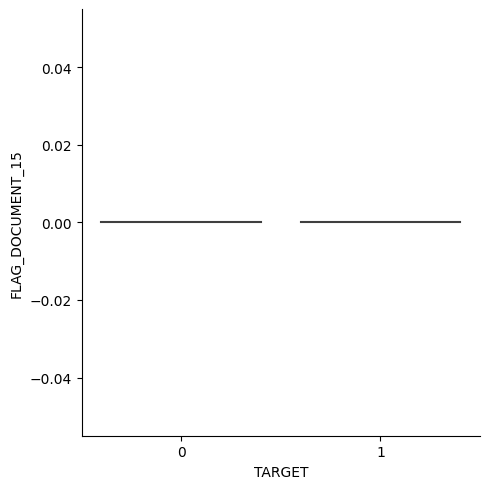

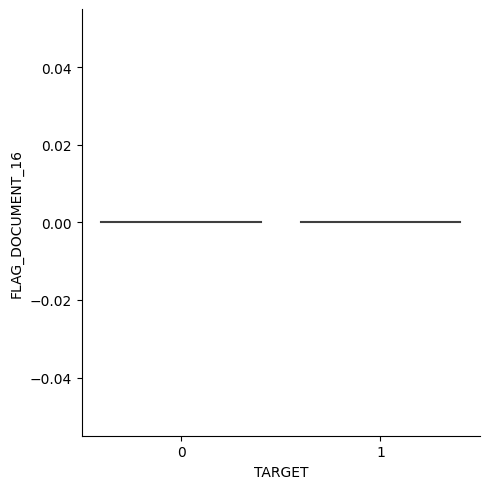

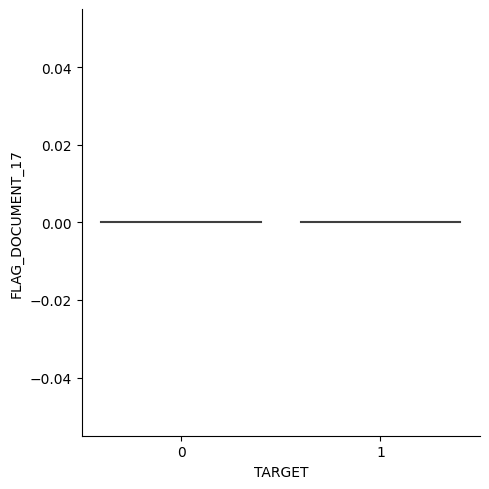

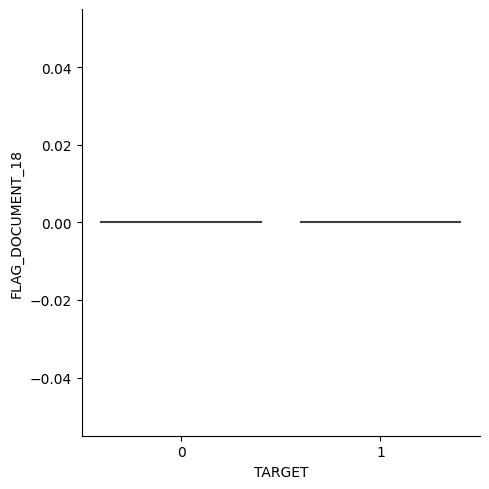

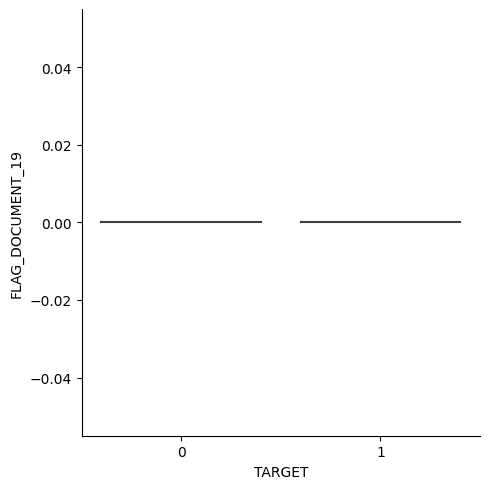

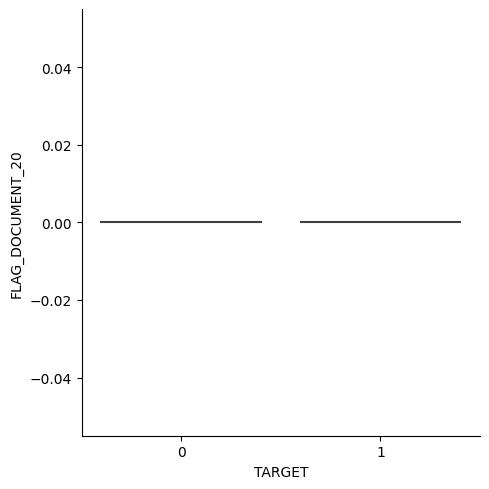

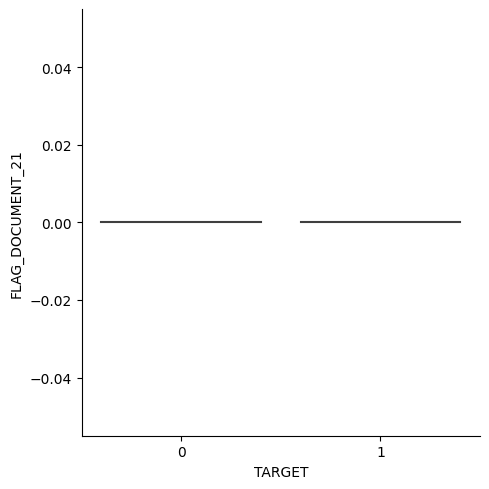

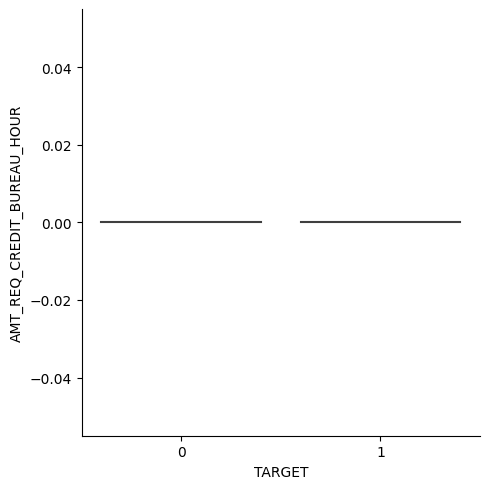

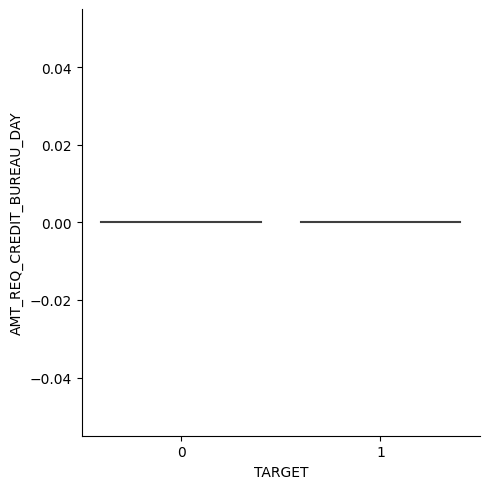

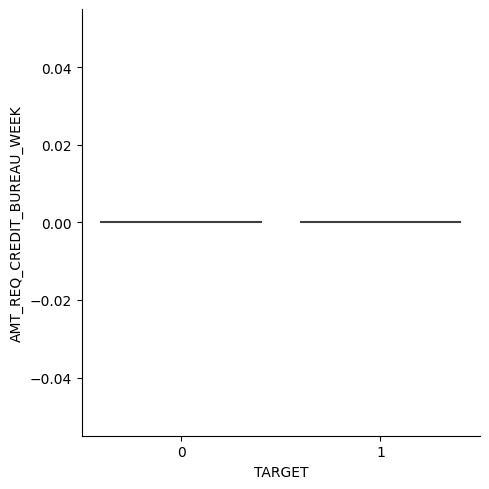

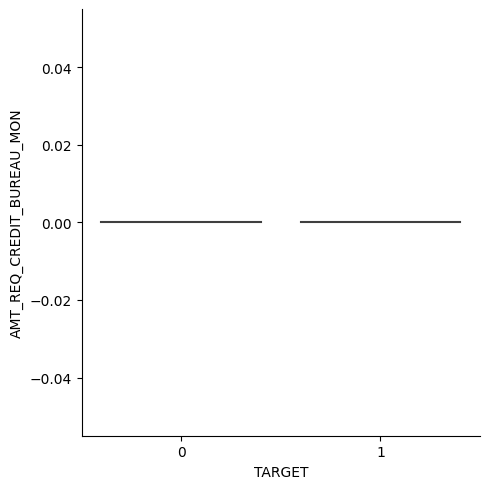

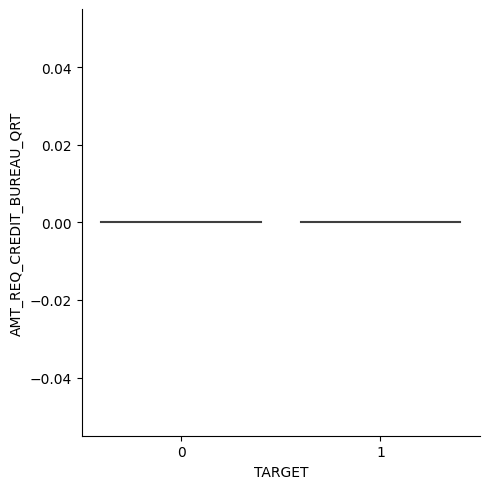

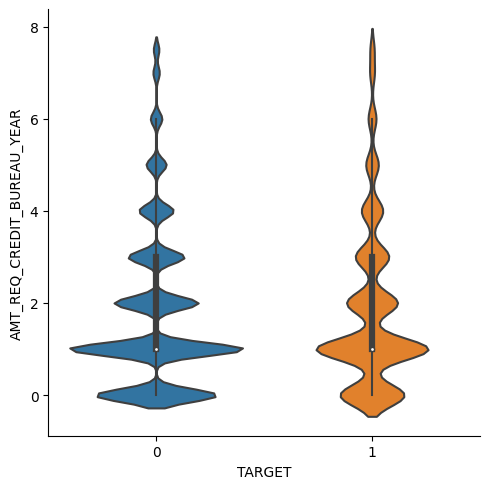

In [26]:
import seaborn as sns

for i in num_cols:
    sns.catplot(x=target, y = i,data = df_train, kind="violin")

In [27]:
random_state_val =777
test_size_val =0.1

df_train, df_val = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

drop_col = [target, index_col]
y_nm = target

df_train_x = df_train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(df_train[y_nm])

df_val_x = df_val.drop(drop_col, axis = 1)
df_val_y = pd.DataFrame(df_val[y_nm])

In [28]:
LGBClassifier = lgb.LGBMClassifier(objective='binary',
                                   nthread=4,
                                   n_estimators=10000,
                                   learning_rate=0.02,
                                   num_leaves=34,
                                   colsample_bytree=0.9497036,
                                   subsample=0.8715623,
                                   max_depth=8,
                                   reg_alpha=0.041545473,
                                   reg_lambda=0.0735294,
                                   min_split_gain=0.0222415,
                                   min_child_weight=39.3259775,
                                   silent=-1,
                                   random_state = 42)

In [29]:
start = datetime.datetime.now()
lgbm = LGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], 
                       eval_metric ='auc',
                       early_stopping_rounds = 200,
                       verbose = True)
end = datetime.datetime.now()
end-start

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[1]	valid_0's auc: 0.714504	valid_0's binary_logloss: 0.279504	valid_1's auc: 0.71256	valid_1's binary_logloss: 0.278415
[2]	valid_0's auc: 0.723525	valid_0's binary_logloss: 0.278678	valid_1's auc: 0.721185	valid_1's binary_logloss: 0.27761
[3]	valid_0's auc: 0.726535	valid_0's binary_logloss: 0.277635	valid_1's auc: 0.724509	valid_1's binary_logloss: 0.276574
[4]	valid_0's auc: 0.726856	valid_0's binary_logloss: 0.276657	valid_1's auc: 0.724355	valid_1's binary_logloss: 0.275612
[5]	valid_0's auc: 0.727174	valid_0's binary_logloss: 0.275737	valid_1's auc: 0.723869	valid_1's binary_logloss: 0.27471
[6]	valid_0's auc: 0.727007	valid_0's binary_logloss: 0.274869	valid_1's auc: 0.723689	valid_1's binary_logloss: 0.273858
[7]	valid_0's auc: 0.727287	valid_0's binary_logloss: 0.274041	valid_1's auc: 0.723639	valid_1's binary_logloss: 0.27305
[8]	valid_0's auc: 0.727517	val

datetime.timedelta(seconds=158, microseconds=722744)

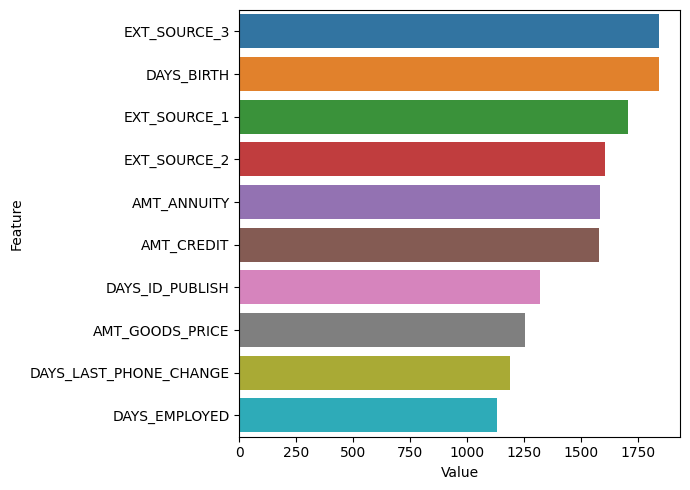

In [30]:
feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_train_x.columns), reverse = True), columns = ['Value', 'Feature'])

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:10].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()

In [31]:
fpr, tpr, _ = roc_curve(df_val_y, lgbm.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold =0.
val_y_prob = lgbm.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold))
print('Complete')

Max_value =0.760398, optimized_threshold=0.600000
Complete


In [32]:
predict_lgbm = lgbm.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

In [33]:
conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0         28273          2457
Predicted Value 1             9            13

2. Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28282
           1       0.59      0.01      0.01      2470

    accuracy                           0.92     30752
   macro avg       0.76      0.50      0.48     30752
weighted avg       0.89      0.92      0.88     30752

3. Model Metric Sumamry
 - Accuracy Rate    : 91.981 %
 - Recall Rate      : 0.526 %
 - Precision Rate   : 59.091 %
 - Specificity Rate : 99.968 %
 - F1 Score         : 1.043 
 - ROC AUC          : 76.040 


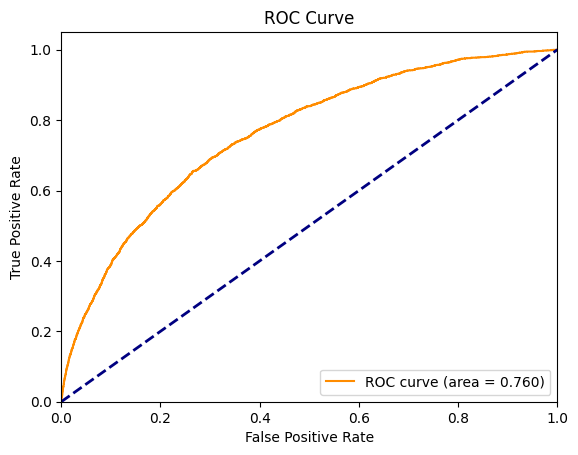

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
XGBClassifier = xgb.XGBClassifier(max_depth = 6,
                                 learning_rate = 0.01,
                                 n_estimators = 10000,
                                 objective = 'binary:logistic',
                                 tree_method = 'gpu_hist',
                                 booster = 'gbtree',
                                 seed = 23,
                                 min_child_weight = 35,
                                 subsample = 0.7,
                                 alpha = 0.25,
                                 n_jobs = -1
                                 )

In [36]:
start = datetime.datetime.now()
xgb = XGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], 
                       eval_metric = 'auc',
                       early_stopping_rounds = 200,
                       verbose = True)
end = datetime.datetime.now()
end-start

[0]	validation_0-auc:0.71847	validation_1-auc:0.71329
[1]	validation_0-auc:0.72177	validation_1-auc:0.71638
[2]	validation_0-auc:0.72319	validation_1-auc:0.71706
[3]	validation_0-auc:0.72436	validation_1-auc:0.71894
[4]	validation_0-auc:0.72501	validation_1-auc:0.71945
[5]	validation_0-auc:0.72591	validation_1-auc:0.72046
[6]	validation_0-auc:0.72654	validation_1-auc:0.72164
[7]	validation_0-auc:0.72729	validation_1-auc:0.72211
[8]	validation_0-auc:0.72760	validation_1-auc:0.72306
[9]	validation_0-auc:0.72802	validation_1-auc:0.72374
[10]	validation_0-auc:0.72794	validation_1-auc:0.72319
[11]	validation_0-auc:0.72791	validation_1-auc:0.72303
[12]	validation_0-auc:0.72796	validation_1-auc:0.72302
[13]	validation_0-auc:0.72844	validation_1-auc:0.72367
[14]	validation_0-auc:0.72865	validation_1-auc:0.72414
[15]	validation_0-auc:0.72863	validation_1-auc:0.72406
[16]	validation_0-auc:0.72894	validation_1-auc:0.72434
[17]	validation_0-auc:0.72909	validation_1-auc:0.72440
[18]	validation_0-au

datetime.timedelta(seconds=56, microseconds=920316)

In [37]:
fi_vals = xgb.get_booster().get_score(importance_type = 'weight')
fi_dict = {df_train_x.columns[i]:float(fi_vals.get('f'+str(i),0.)) for i in range(len(df_train_x.columns))}
feature_importance_ = sorted(fi_dict.items(), key=operator.itemgetter(1), reverse=True)
feature_importance_result = OrderedDict(feature_importance_)

importance = pd.DataFrame(feature_importance_)
importance.columns = ['feature','weight']
importance.head(10)

feature  weight
0            EXT_SOURCE_2  5695.0
1            EXT_SOURCE_3  5606.0
2              DAYS_BIRTH  5328.0
3            EXT_SOURCE_1  4749.0
4             AMT_ANNUITY  4374.0
5         DAYS_ID_PUBLISH  4131.0
6              AMT_CREDIT  4078.0
7           DAYS_EMPLOYED  4033.0
8  DAYS_LAST_PHONE_CHANGE  3859.0
9       DAYS_REGISTRATION  3559.0

<Axes: ylabel='feature'>

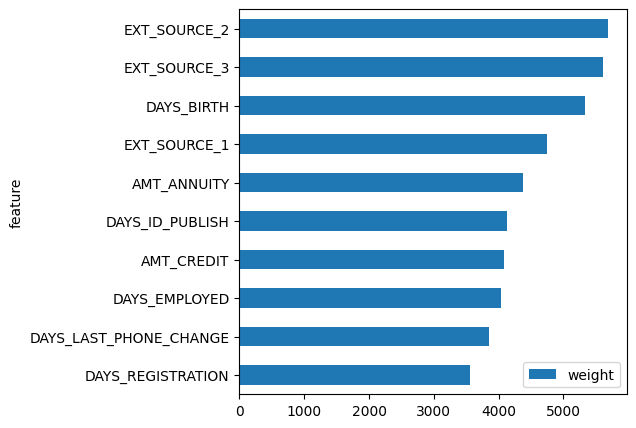

In [38]:
importance_ten = importance[:10]
importance_ten.set_index('feature').sort_values(by='weight').plot(kind='barh', figsize=(5, 5))

In [39]:
fpr, tpr, _ = roc_curve(df_val_y, xgb.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold_2 =0.
val_y_prob = xgb.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold_2 = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold_2 = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold_2 = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold_2 = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold_2 = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold_2))
print('Complete')

Max_value =0.761032, optimized_threshold=0.600000
Complete


In [40]:
predict_xgb = xgb.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_xgb > opt_threshold_2, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0         28274          2454
Predicted Value 1             8            16

2. Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28282
           1       0.67      0.01      0.01      2470

    accuracy                           0.92     30752
   macro avg       0.79      0.50      0.49     30752
weighted avg       0.90      0.92      0.88     30752

3. Model Metric Sumamry
 - Accuracy Rate    : 91.994 %
 - Recall Rate      : 0.648 %
 - Precision Rate   : 66.667 %
 - Specificity Rate : 99.972 %
 - F1 Score         : 1.283 
 - ROC AUC          : 76.103 


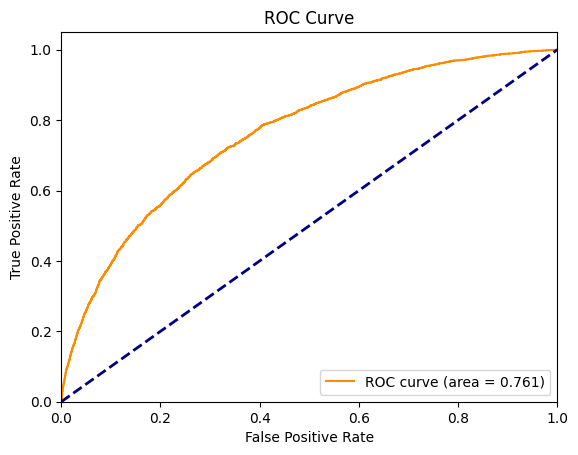

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_xgb)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

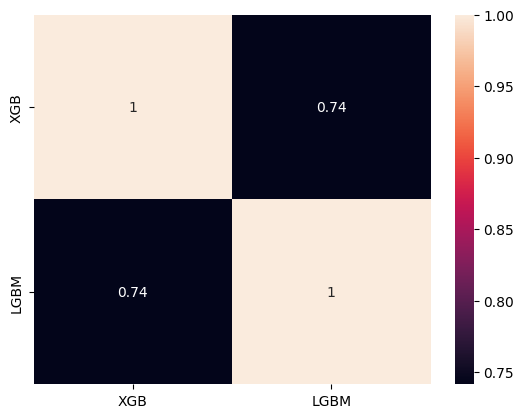

In [45]:
# df_test = df_test.drop(index_col, axis = 1)

test_xgb = pd.Series(xgb.predict(df_test.values), name="XGB")
test_lgbm = pd.Series(lgbm.predict(df_test.values), name="LGBM")

# Concatenate all classifier results
ensemble_results = pd.concat([test_xgb,test_lgbm],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [46]:
votingC = VotingClassifier(estimators=[('xgb', xgb),('lgbm', lgbm)], voting='soft')
votingC = votingC.fit(df_train_x.values, df_train_y.values)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [47]:
fpr, tpr, _ = roc_curve(df_val_y, votingC.predict_proba(df_val_x.values)[:, 1])
roc_auc = auc(fpr, tpr)

result_lst =[]
max_value =0.
opt_threshold_3 =0.
val_y_prob = votingC.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if choice == 'Accuracy':
        if max_value <= accuracy:
            max_value = accuracy
            opt_threshold_3 = threshold
    elif choice == 'Precision':
        if max_value <= precision:
            max_value = precision
            opt_threshold_3 = threshold
    elif choice == 'Recall':
        if max_value <= recall:
            max_value = recall
            opt_threshold_3 = threshold
    elif choice == 'F1_Score':
        if max_value <= f1_score:
            max_value = f1_score
            opt_threshold_3 = threshold
    elif choice == 'roc_auc':
        if max_value <= roc_auc:
            max_value = roc_auc
            opt_threshold_3 = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max_value =%f, optimized_threshold=%f'%(max_value, opt_threshold_3))
print('Complete')

Max_value =0.752580, optimized_threshold=0.600000
Complete


In [48]:
predict_votingC = votingC.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_votingC > opt_threshold_3, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0         28259          2440
Predicted Value 1            23            30

2. Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28282
           1       0.57      0.01      0.02      2470

    accuracy                           0.92     30752
   macro avg       0.74      0.51      0.49     30752
weighted avg       0.89      0.92      0.88     30752

3. Model Metric Sumamry
 - Accuracy Rate    : 91.991 %
 - Recall Rate      : 1.215 %
 - Precision Rate   : 56.604 %
 - Specificity Rate : 99.919 %
 - F1 Score         : 2.378 
 - ROC AUC          : 75.258 


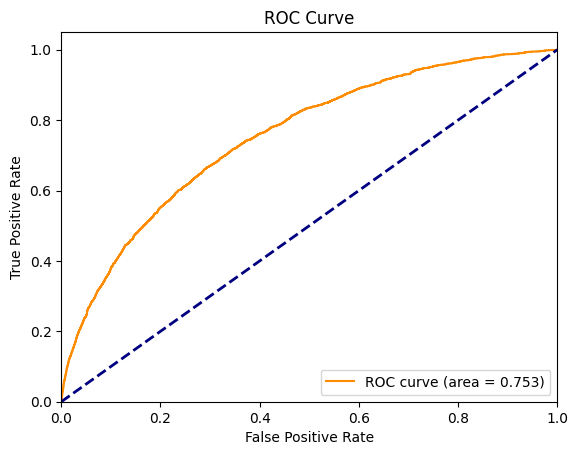

In [49]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_votingC)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [50]:
predict_votingC = votingC.predict_proba(df_test.values)[:,1]

df_test = pd.read_csv(os.path.join(dir_ad, test))
test_result= pd.DataFrame(predict_votingC)
test_result.columns = [target]
predict = test_result[target]
Id_No = df_test[index_col]
submission = pd.DataFrame({index_col: Id_No, target: predict})
# submission[target] = submission[target].astype('Int64')
submission.to_csv('submission.csv', index=False)
submission.head()

SK_ID_CURR    TARGET
0      100001  0.025198
1      100005  0.123581
2      100013  0.037584
3      100028  0.023026
4      100038  0.061340